In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import matplotlib as mpl
import seaborn as sns
from pathlib import Path
import numpy as np
from adjustText import adjust_text

# Plot settings
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 7)
mpl.rcParams["legend.fontsize"] = 14
%matplotlib inline


In [28]:
# Import paths and region maps from config.py
import sys
from pathlib import Path

# Adjust path to project root so config.py is visible
sys.path.append(str(Path().resolve().parents[1]))

from config import (
    GAS_PRICE_SHOCK_DIR,
    GAS_PRICE_SHOCK_SRC,
    GAS_PRICE_SHOCK_NOTEBOOKS,
    GAS_PRICE_SHOCK_OUTPUTS,
    GAS_PRICE_SHOCK_DATA,
    GAS_PRICE_SHOCK_VIS,
    EU28_COUNTRIES,
    NACE_SHORT_DESCRIPTION_MAP
)

In [29]:
# ── Un‐weighted shock results ────────────────────────────────────
UNWEIGHTED_EXTRA = pd.read_csv(
    GAS_PRICE_SHOCK_OUTPUTS / "results_extra_2021.csv",
    index_col=["Country", "Sector"]
)

UNWEIGHTED_INTRA_EXTRA = pd.read_csv(
    GAS_PRICE_SHOCK_OUTPUTS / "results_intra_extra_2021.csv",
    index_col=["Country", "Sector"]
)

# ── Weighted impacts directory ───────────────────────────────────
WI = GAS_PRICE_SHOCK_OUTPUTS / "weighted_impacts"

# ── CPI-weighted by destination country ──────────────────────────
CPI_CTRY_EXTRA      = pd.read_csv(
    WI / "extra_cpi_country_impacts_2021.csv",
    index_col=["Country", "Sector"]
)
CPI_CTRY_INTRA_EXTRA       = pd.read_csv(
    WI / "full_cpi_country_impacts_2021.csv",
    index_col=["Country", "Sector"]
)

# ── CPI-weighted EU-28 aggregate impacts ────────────────────────
CPI_EU28_EXTRA      = pd.read_csv(
    WI / "extra_cpi_applied_total_impact_eu28.csv",
    index_col=["Country", "Sector"]
)
CPI_EU28_INTRA_EXTRA       = pd.read_csv(
    WI / "full_cpi_applied_total_impact_eu28.csv",
    index_col=["Country", "Sector"]
)


In [30]:
# -------------------------------------------------------------------
# Helper utilities
# -------------------------------------------------------------------
EU28 = EU28_COUNTRIES

def dynamic_ylim(series, step=0.05):
    """Return a nice y-axis ceiling given a Series of positive values."""
    return np.ceil(series.max() / step) * step

def bar_perc(ax):
    """Format y-axis as percentages on *ax*."""
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:.2f}%"))

def top_n(df_col, n=20):
    """Return largest n from a (possibly MultiIndexed) column Series."""
    return df_col.sort_values(ascending=False).head(n)

def bar_perc(ax, axis="y"):
    """
    Format a single axis (x or y) as percentages with two decimals.

    Parameters
    ----------
    ax   : matplotlib Axes
    axis : "x" or "y"   (default = "y")
    """
    fmt = mtick.FuncFormatter(lambda x, _: f"{x:.2f}%")
    if axis == "x":
        ax.xaxis.set_major_formatter(fmt)
    else:
        ax.yaxis.set_major_formatter(fmt)


In [31]:
def plot_country_stack_h_sorted(country, *, multiply_100=False):
    """
    Plot a horizontal stacked bar chart of the top 15 sectoral CPI-weighted impacts for a given country.

    The function visualizes the contribution of Extra-EU and Intra-EU gas price shocks to the consumer price index (CPI)
    for the specified country, sorted by the largest total impact (intra + extra) per sector. The top 15 sectors are shown.
    Optionally, the impacts can be scaled to percentage points.

    Parameters
    ----------
    country : str
        ISO country code (e.g., "DE", "FR") for which to plot the impacts.
    multiply_100 : bool, optional
        If True, scale the CPI impacts by 100 to show percentage points (default: False).
    """
    code = country.strip().upper()
    # column name: ISO or ISO_impact
    if code in CPI_CTRY_EXTRA.columns:
        col = code
    elif f"{code}_impact" in CPI_CTRY_EXTRA.columns:
        col = f"{code}_impact"
    else:
        raise KeyError(f"No column for '{code}'")
    
    extra = CPI_CTRY_EXTRA[col].copy()
    intra_extra = CPI_CTRY_INTRA_EXTRA[col].copy()
    if multiply_100:
        extra *= 100
        intra_extra *= 100
    
    # largest first (no reverse)
    top20 = intra_extra.nlargest(15)
    
    labels = [
        f"{idx[0]} – {NACE_SHORT_DESCRIPTION_MAP.get(idx[1], idx[1])}"
        for idx in top20.index
    ]
    
    diff = intra_extra.loc[top20.index] - extra.loc[top20.index]
    
    fig, ax = plt.subplots(figsize=(14, 8))
    y = range(len(top20))
    ax.barh(y, extra.loc[top20.index], color="royalblue", label="Extra-EU")
    ax.barh(y, diff, left=extra.loc[top20.index],
            color="darkorange", label="Intra-EU")
    
    unit = "pp" if multiply_100 else "points"
    ax.set(
        xlabel=f"ΔCPI ({unit})",
        yticks=y,
        yticklabels=labels
    )
    ax.set_title(f"CPI-weighted impact in {code}", fontsize=16, fontweight="bold")
    ax.invert_yaxis()   # keeps largest (y=0) at top
    ax.grid(axis="x", linestyle="--", alpha=0.7)
    if multiply_100:
        bar_perc(ax, axis="x")
    ax.legend(loc="lower right")
    fig.tight_layout()
    plt.show()


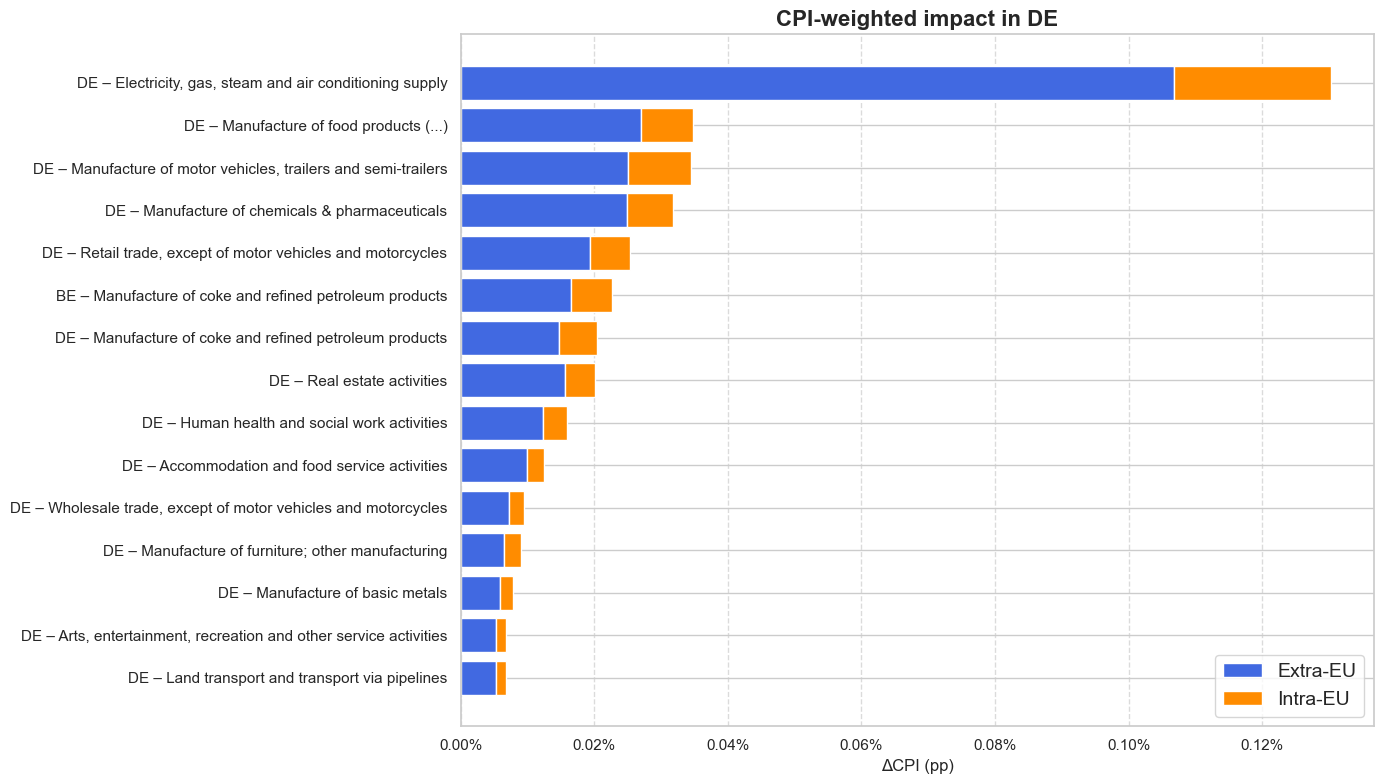

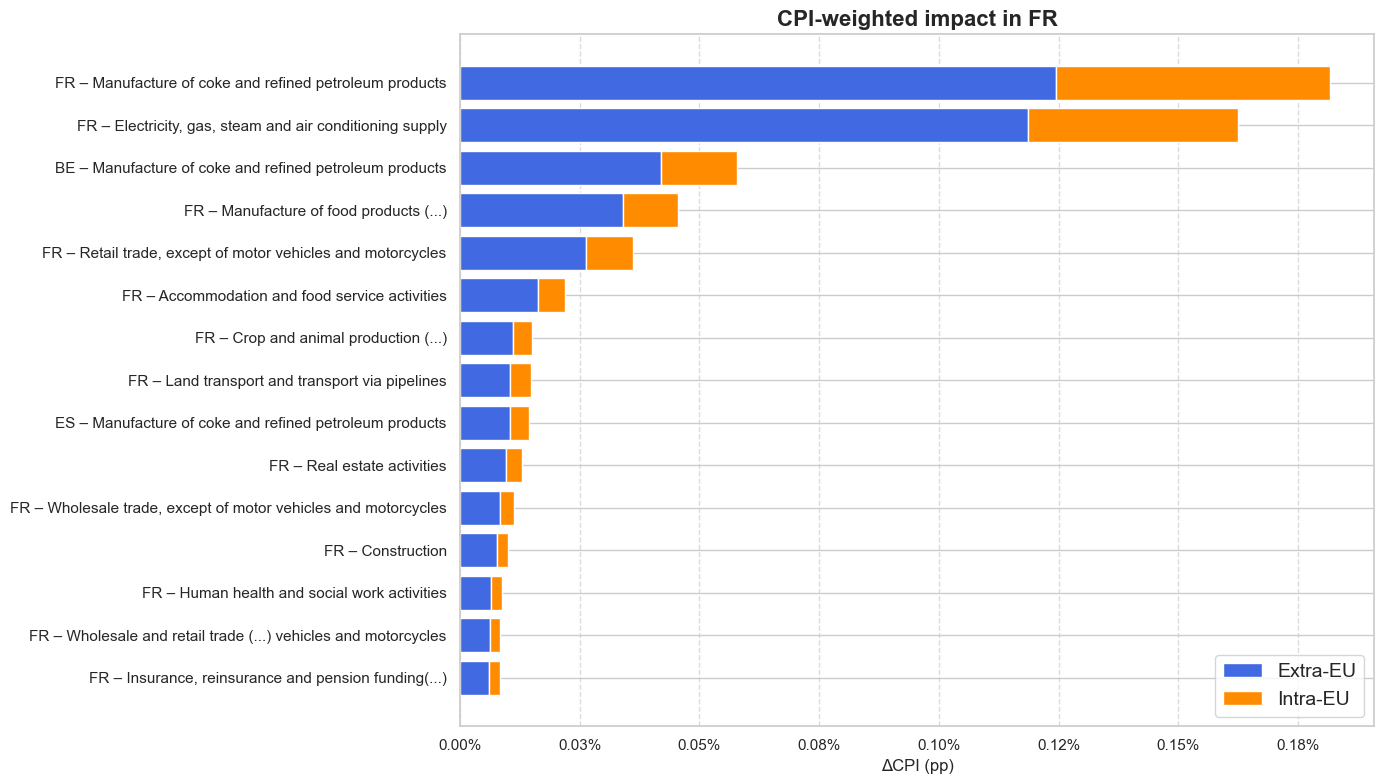

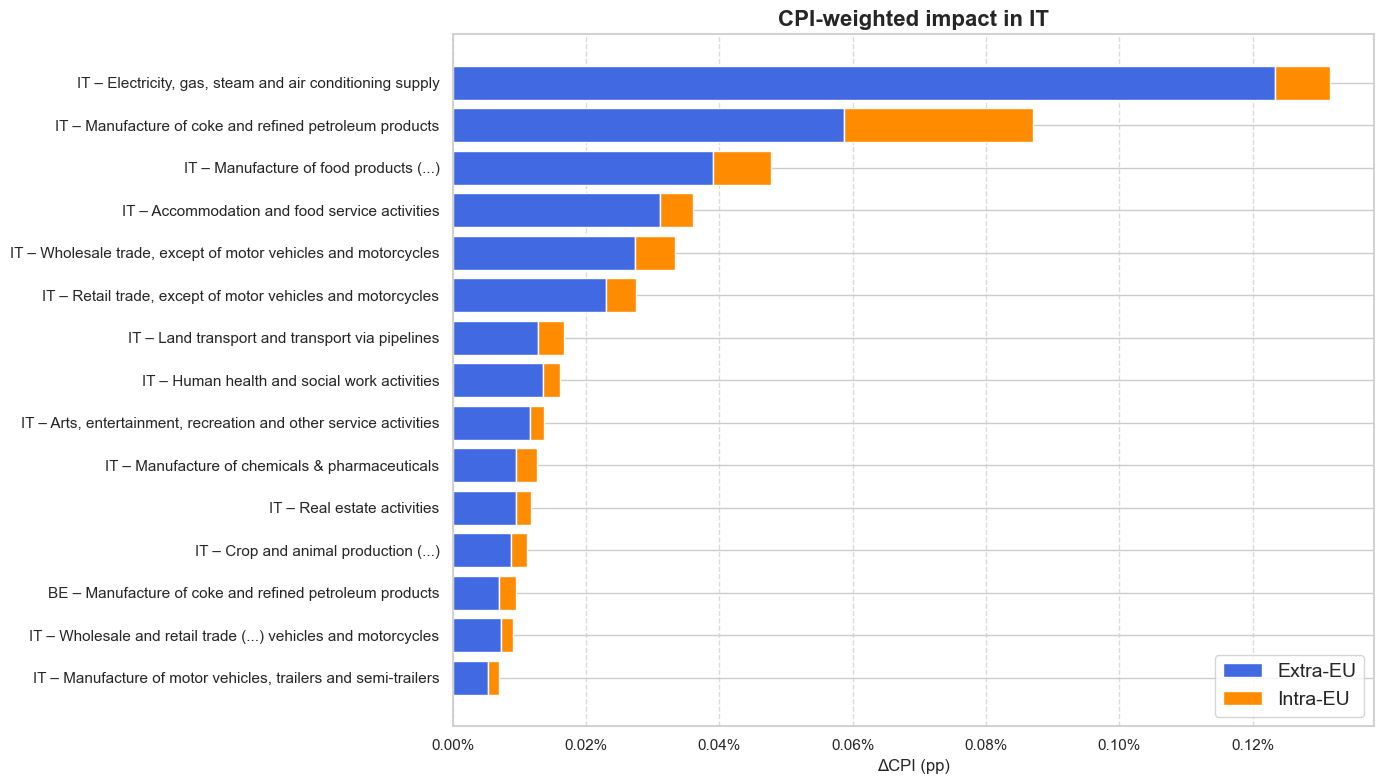

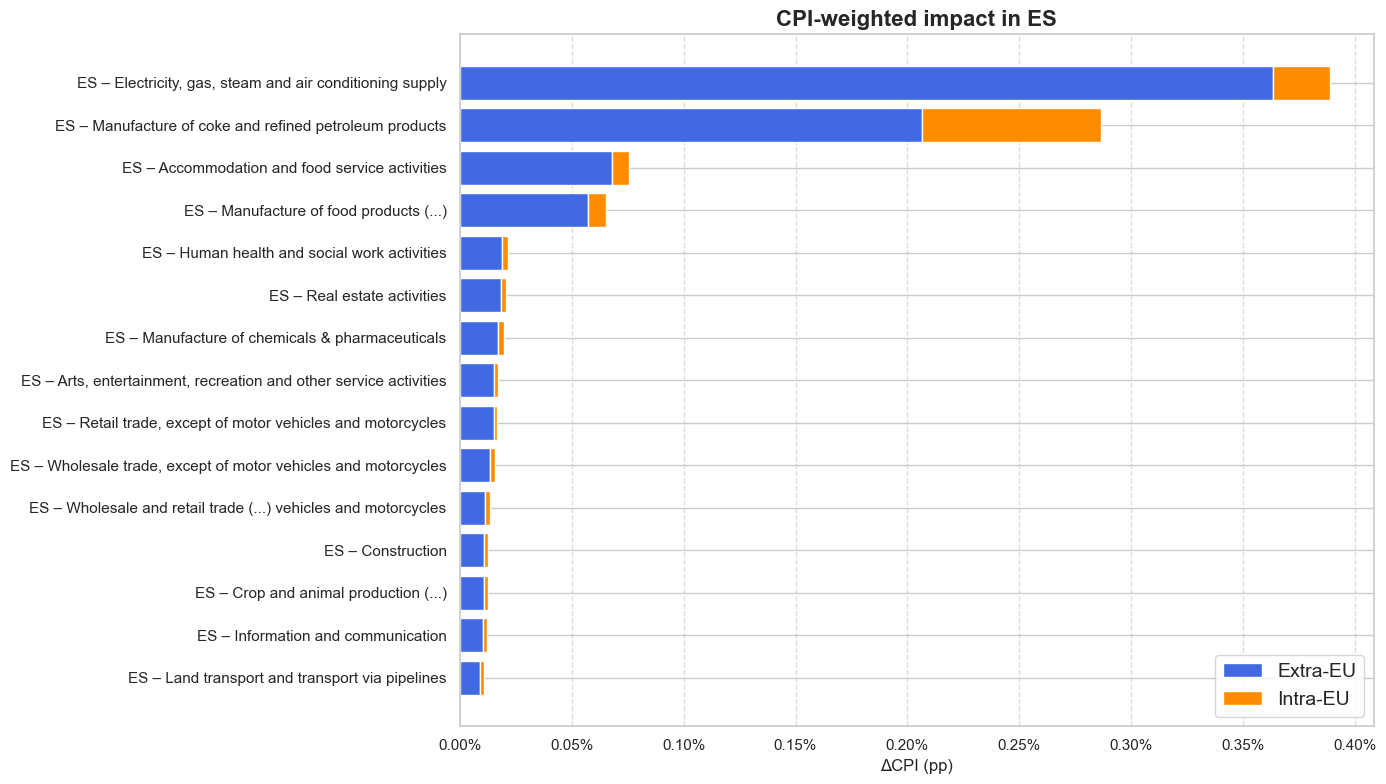

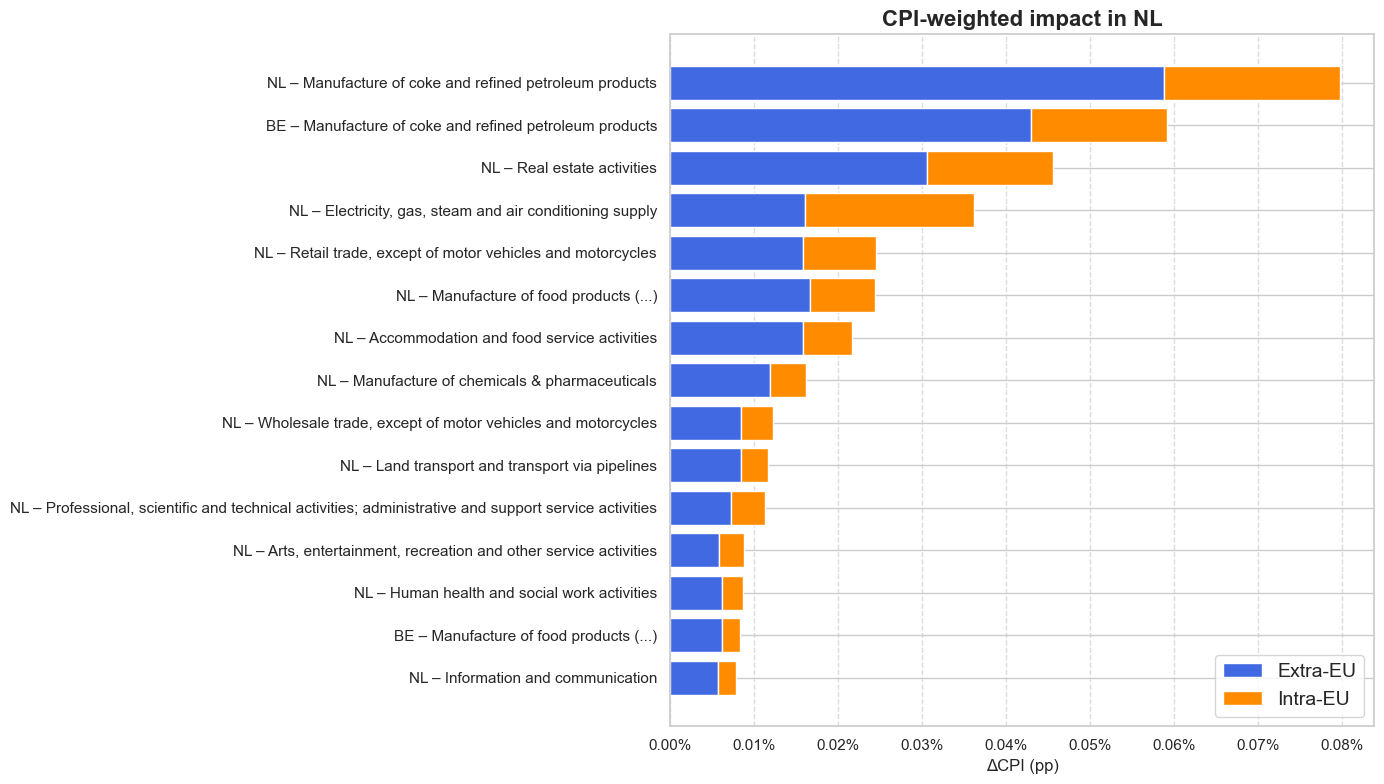

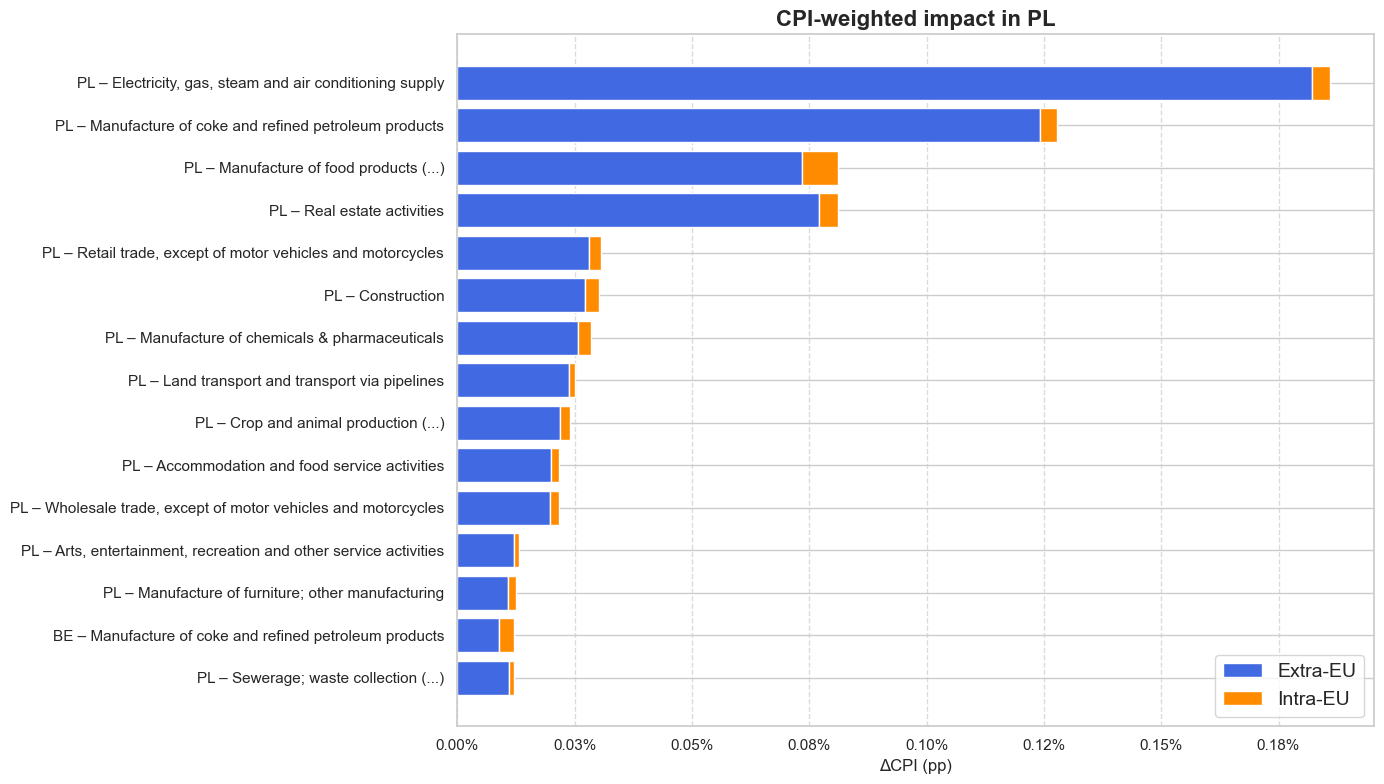

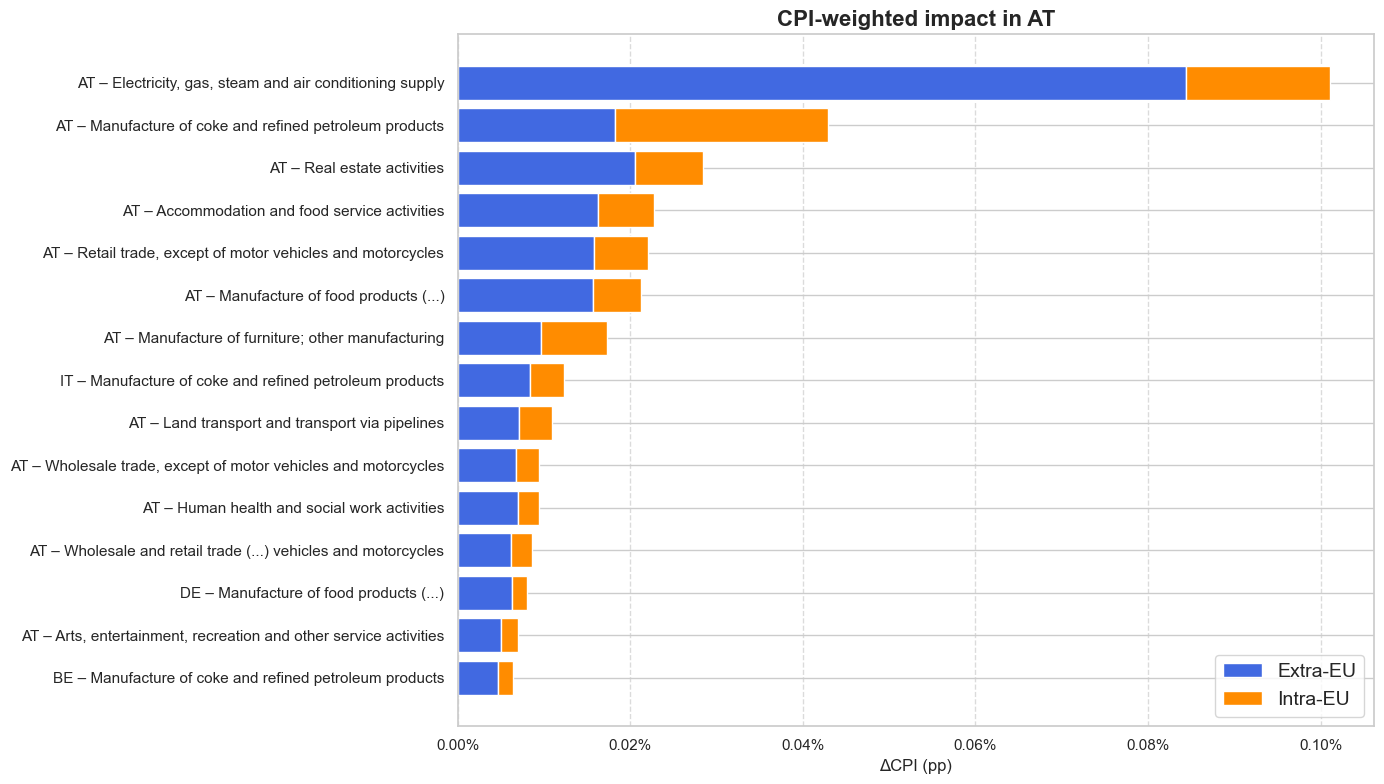

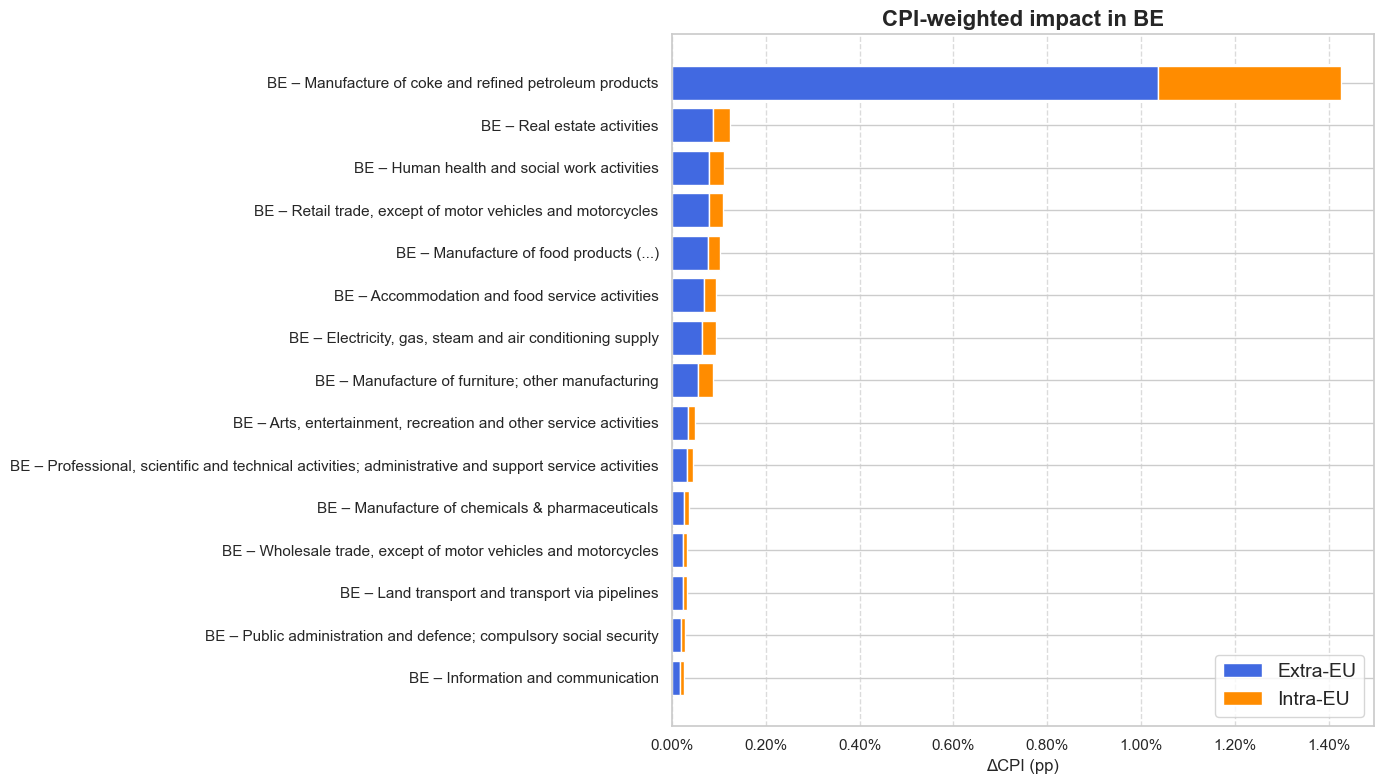

In [32]:
plot_country_stack_h_sorted("DE", multiply_100=True)
plot_country_stack_h_sorted("FR", multiply_100=True)
plot_country_stack_h_sorted("IT", multiply_100=True)
plot_country_stack_h_sorted("ES", multiply_100=True)
plot_country_stack_h_sorted("NL", multiply_100=True)
plot_country_stack_h_sorted("PL", multiply_100=True)
plot_country_stack_h_sorted("AT", multiply_100=True)
plot_country_stack_h_sorted("BE", multiply_100=True)

In [33]:
def plot_origin_country_stack(*, save=True, multiply_100=False):
    """
    Stacked bar: total CPI impact on the EU-28, summed by *producer* country.

    Parameters
    ----------
    save          : bool   — if True, PNG is written to GAS_PRICE_SHOCK_VIS
    multiply_100  : bool   — if True, convert CPI points → percentage-points
    """
    # ---------------------------------------------------------------
    # Determine which column contains the EU-wide CPI impact
    # ---------------------------------------------------------------
    if "EU28_impact" in CPI_EU28_EXTRA.columns:
        col = "EU28_impact"
    elif "EU28" in CPI_EU28_EXTRA.columns:
        col = "EU28"
    else:
        raise KeyError("Neither 'EU28_impact' nor 'EU28' column found "
                       "in CPI_EU28_EXTRA.")

    # ---------------------------------------------------------------
    # Aggregate by producer country (index level 0)
    # ---------------------------------------------------------------
    extra_by_origin       = CPI_EU28_EXTRA.groupby(level=0)[col].sum()
    intra_extra_by_origin = CPI_EU28_INTRA_EXTRA.groupby(level=0)[col].sum()
    intra_only_by_origin  = intra_extra_by_origin - extra_by_origin

    if multiply_100:
        extra_by_origin      *= 100
        intra_only_by_origin *= 100
        intra_extra_by_origin *= 100

    # Sort countries by total impact (descending)
    order = intra_extra_by_origin.sort_values(ascending=False).index

    # ---------------------------------------------------------------
    # Plot
    # ---------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(14, 7))

    ax.bar(order, extra_by_origin.loc[order],
           label="Extra-EU",  color="royalblue")
    ax.bar(order, intra_only_by_origin.loc[order],
           bottom=extra_by_origin.loc[order],
           label="Intra-EU",  color="darkorange")

    unit = "pp" if multiply_100 else "points"
    ax.set(
        title="Origin-Country Contribution to EU-28 CPI",
        ylabel=f"Total ΔCPI ({unit})",
        xlabel="Producer country"
    )
    ax.set_title(ax.get_title(), fontsize=16, fontweight="bold")
    ax.tick_params(axis="x", labelrotation=45)     # rotate
    plt.setp(ax.get_xticklabels(), ha="right")     # align right

    ax.grid(axis="y", linestyle="--", alpha=0.7)

    # format y-axis as percentages if we scaled ×100
    if multiply_100:
        ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:.2f}%"))

    ax.legend(loc="upper right")
    fig.tight_layout()

    if save:
        fname = GAS_PRICE_SHOCK_VIS / "Origin_Country_Stack_EU28.png"
        fig.savefig(fname, dpi=300)
        print("Saved:", fname)
    else:
        plt.show()


Saved: C:\Users\danie\Nextcloud\Coding\Masterthesis\part_gas_price_shock\visualizations\Origin_Country_Stack_EU28.png


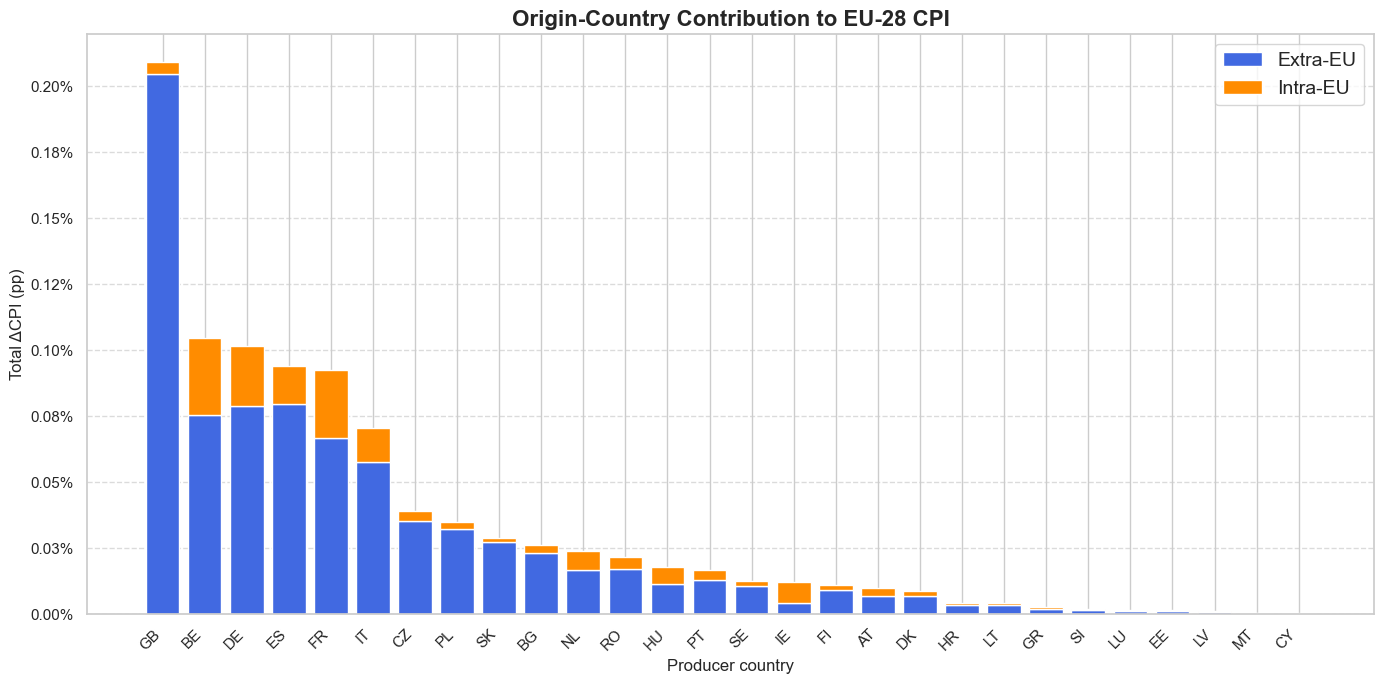

In [34]:
plot_origin_country_stack(multiply_100=True, save=True)

In [35]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# -------------------------------------------------------------------
# Cumulative destination-side impact (EU-28 countries)
# -------------------------------------------------------------------
def plot_destination_cumulative_stack(*, multiply_100=False, save=True):
    """
    Stacked bars: total CPI impact PER DESTINATION country (EU-28).

    Parameters
    ----------
    multiply_100 : bool  – show percentage-points (×100) instead of CPI points
    save         : bool  – if True, PNG is written to GAS_PRICE_SHOCK_VIS
    """

    # --- determine column naming scheme --------------------------------
    sample_col = next(iter(CPI_CTRY_EXTRA.columns))
    use_suffix  = sample_col.endswith("_impact")          # e.g. "DE_impact"

    # list of destination ISO codes (import from config or define here)
    from config import EU28_COUNTRIES
    dest_cols = [f"{c}_impact" if use_suffix else c for c in EU28_COUNTRIES]

    # --- aggregate over all producer/sector rows -----------------------
    extra_total       = CPI_CTRY_EXTRA[dest_cols].sum(axis=0)
    intra_extra_total = CPI_CTRY_INTRA_EXTRA[dest_cols].sum(axis=0)
    intra_only_total  = intra_extra_total - extra_total

    if multiply_100:
        extra_total       *= 100
        intra_only_total  *= 100
        intra_extra_total *= 100

    # order bars by total impact (descending)
    order = intra_extra_total.sort_values(ascending=False).index

    # strip "_impact" for cleaner x-labels
    labels = [c.replace("_impact", "") for c in order]

    # --- plot ----------------------------------------------------------
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.bar(labels, extra_total[order], label="Extra-EU",  color="royalblue")
    ax.bar(labels, intra_only_total[order],
           bottom=extra_total[order],    label="Intra-EU", color="darkorange")

    unit = "pp" if multiply_100 else "points"
    ax.set(
        title="Cumulative CPI Impact on Individual Country Inflation",
        ylabel=f"Total ΔCPI ({unit})",
        xlabel="Destination country"
    )
    ax.set_title(ax.get_title(), fontsize=16, fontweight="bold")
    ax.tick_params(axis="x", rotation=45, labelrotation=45)
    plt.setp(ax.get_xticklabels(), ha="right")
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    if multiply_100:
        ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:.2f}%"))

    ax.legend(loc="upper right")
    fig.tight_layout()

    if save:
        fname = GAS_PRICE_SHOCK_VIS / "Destination_Cumulative_Stack_EU28.png"
        fig.savefig(fname, dpi=300)
        print("Saved:", fname)
    else:
        plt.show()

Saved: C:\Users\danie\Nextcloud\Coding\Masterthesis\part_gas_price_shock\visualizations\Destination_Cumulative_Stack_EU28.png


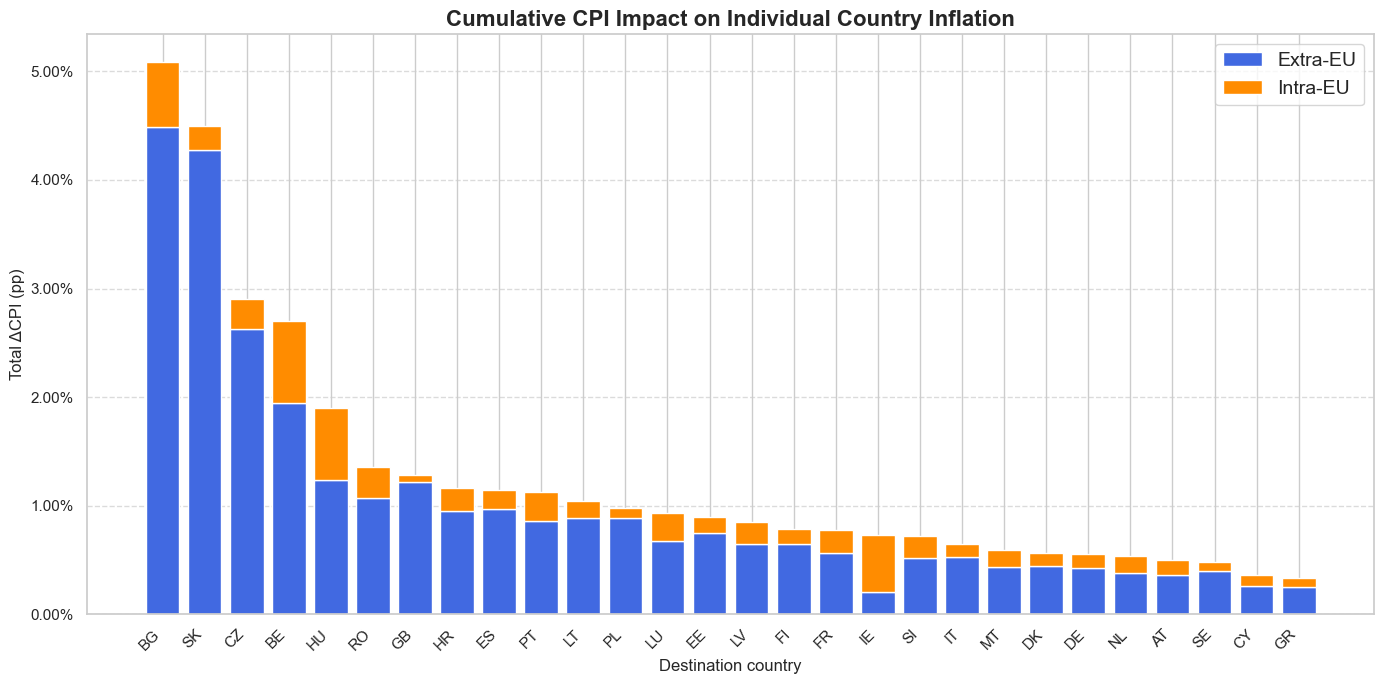

In [36]:
plot_destination_cumulative_stack(multiply_100=True)

In [37]:
def plot_eu28_sector_stack(
    *,
    top_n: int = 30,
    multiply_100: bool = True,
    save: bool = True,
):
    """
    Stacked bars: cumulative CPI impact PER SECTOR for the whole EU-28.

    Parameters
    ----------
    top_n        : int
        Number of sectors to display (default = 30, largest impacts).
    multiply_100 : bool
        If True, convert CPI points to percentage-points (×100) for the x-axis.
    save         : bool
        If True, save the figure as PNG in GAS_PRICE_SHOCK_VIS; otherwise only
        display it inline.
    """
    # ---------------------------------------------------------------
    # Detect the EU-wide impact column
    # ---------------------------------------------------------------
    if "EU28_impact" in CPI_EU28_EXTRA.columns:
        eu_col = "EU28_impact"
    elif "EU28" in CPI_EU28_EXTRA.columns:
        eu_col = "EU28"
    else:
        raise KeyError("EU-wide impact column not found in EU-28 tables.")

    # ---------------------------------------------------------------
    # Aggregate CPI impacts by sector
    # ---------------------------------------------------------------
    extra_sec       = CPI_EU28_EXTRA.groupby(level="Sector")[eu_col].sum()
    intra_extra_sec = CPI_EU28_INTRA_EXTRA.groupby(level="Sector")[eu_col].sum()
    intra_only_sec  = intra_extra_sec - extra_sec

    if multiply_100:
        extra_sec       *= 100
        intra_only_sec  *= 100
        intra_extra_sec *= 100

    # Select TOP-N (largest totals) — keep descending order!
    top = intra_extra_sec.nlargest(top_n)      # largest first
    extra_top = extra_sec[top.index]
    intra_top = intra_only_sec[top.index]

    labels = [NACE_SHORT_DESCRIPTION_MAP.get(s, s) for s in top.index]

    # ---------------------------------------------------------------
    # Plot
    # ---------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(14, 10))
    y = range(len(top))
    ax.barh(y, extra_top, color="royalblue", label="Extra-EU")
    ax.barh(y, intra_top, left=extra_top, color="darkorange", label="Intra-EU")

    unit = "pp" if multiply_100 else "points"
    ax.set(
        title="Cumulative sector impact on EU-28 CPI (gas-price shock)",
        xlabel=f"ΔCPI ({unit})",
        yticks=y,
        yticklabels=labels,
    )
    ax.set_title(ax.get_title(), fontsize=16, fontweight="bold")
    ax.invert_yaxis()                    # puts y=0 (largest) at the top
    ax.grid(axis="x", linestyle="--", alpha=0.7)
    if multiply_100:
        ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:.2f}%"))
    ax.legend(loc="lower right")
    fig.tight_layout()

    # ---------------------------------------------------------------
    # Save or display
    # ---------------------------------------------------------------
    if save:
        fname = GAS_PRICE_SHOCK_VIS / f"Sector_Cumulative_Stack_EU28_top{top_n}.png"
        fig.savefig(fname, dpi=300)
        print("Saved:", fname)
    else:
        plt.show()


Saved: C:\Users\danie\Nextcloud\Coding\Masterthesis\part_gas_price_shock\visualizations\Sector_Cumulative_Stack_EU28_top15.png


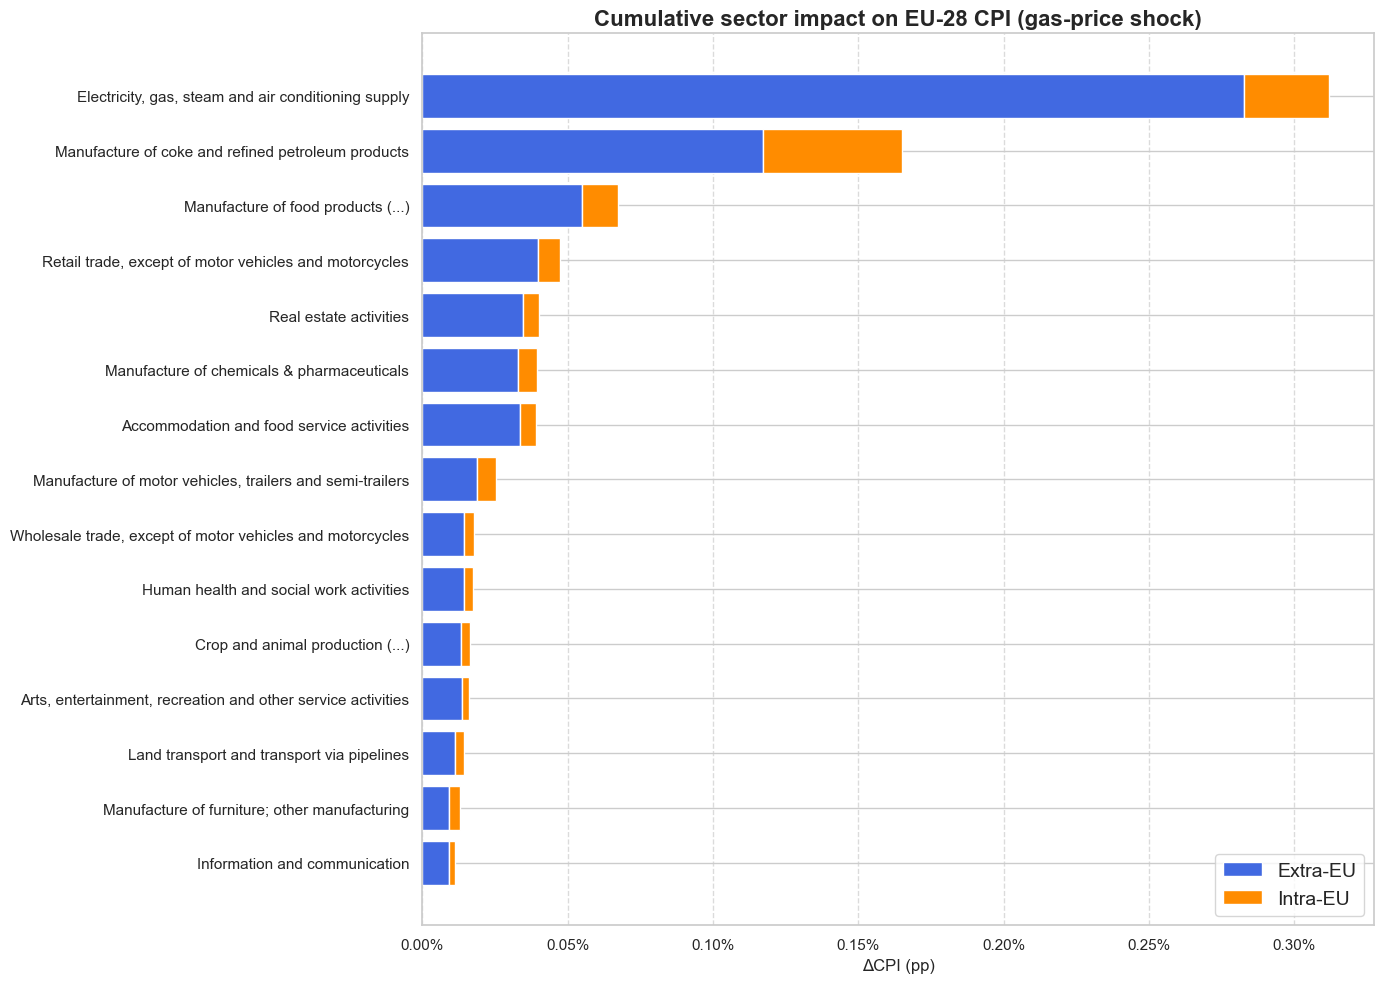

In [38]:
plot_eu28_sector_stack(
    top_n=15,
    multiply_100=True,
    save=True
)

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path
from config import GAS_PRICE_SHOCK_DATA, EU28_COUNTRIES

def plot_gas_flow_heatmap_multiindex(
    year: int = 2021,
    *,
    log_scale: bool = True,
    sort_rows: str = "impact",   # "impact" or None
    sort_cols: str = "alphabet", # "impact" | "alphabet"
    save: bool = False,
):
    """
    Heat-map of forward linkages for natural gas (sector 'B_gas').

    Rows  = producer countries (first index level)
    Cols  = destination countries (first column level)
    Cell  = A-matrix coefficient  (propensity producer → consumer).

    Parameters
    ----------
    year       : int
        File year, e.g. 2021 for 'A_gas_weighted_2021.csv'.
    log_scale  : bool
        If True, colour scale is logarithmic (base-10) with LogNorm.
    sort_rows  : {"impact", None}
        Sort producer rows by total outflow (descending) or keep file order.
    sort_cols  : {"impact", "alphabet"}
        Sort destination columns by total inflow or alphabetically.
    save       : bool
        True ⇒ PNG is written next to the CSV; otherwise only display.
    """
    # -----------------------------------------------------------------
    # 1) Load the technical-coefficients (MultiIndex rows & columns)
    # -----------------------------------------------------------------
    f = GAS_PRICE_SHOCK_DATA / "processed" / f"A_gas_weighted_{year}.csv"
    A = pd.read_csv(f, header=[0, 1], index_col=[0, 1])

    # -----------------------------------------------------------------
    # 2) Filter natural-gas producer rows (sector 'B_gas')
    # -----------------------------------------------------------------
    gas_rows = A.xs("B_gas", level="Sector")

    # -----------------------------------------------------------------
    # 3) Collapse columns to country totals (level-0 of the column MI)
    # -----------------------------------------------------------------
    flows = (
        gas_rows.groupby(axis=1, level=0).sum()
                .reindex(columns=EU28_COUNTRIES, fill_value=0)
    )

    # -----------------------------------------------------------------
    # 4) Optional sorting
    # -----------------------------------------------------------------

    if sort_rows == "impact":
        producer_order = flows.sum(axis=1).sort_values(ascending=False).index
        flows = flows.loc[producer_order]

    elif sort_rows == "alphabet":
        flows = flows.sort_index(axis=0)              # simple A→Z

    if sort_cols == "impact":
        flows = flows.loc[:, flows.sum(axis=0).sort_values(ascending=False).index]

    elif sort_cols == "alphabet":
        flows = flows.sort_index(axis=1)              # A→Z


    # -----------------------------------------------------------------
    # 5) Build the heat-map
    # -----------------------------------------------------------------
    n_rows, n_cols = flows.shape
    fig_w = max(10, 0.4 * n_cols)   # 0.4" per column
    fig_h = max(8, 0.35 * n_rows)   # 0.35" per row

    plt.figure(figsize=(fig_w, fig_h))

    if log_scale:
        sns.heatmap(
            flows + 1e-12,  # avoid log(0)
            cmap="YlOrBr",
            linewidths=0.3,
            linecolor="grey",
            norm=LogNorm(vmin=flows[flows>0].min().min(), vmax=flows.max().max()),
            cbar_kws={"label": "Forward linkage (log scale)"},
        )
    else:
        sns.heatmap(
            flows,
            cmap="YlOrBr",
            linewidths=0.3,
            linecolor="grey",
            cbar_kws={"label": "Forward linkage"},
        )

    plt.title(f"Natural-gas forward linkages (B_gas) - {year}",
              fontsize=16, fontweight="bold")
    plt.xlabel("Destination country")
    plt.ylabel("Producer country")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()

    # -----------------------------------------------------------------
    # 6) Save or display
    # -----------------------------------------------------------------
    if save:
        out = GAS_PRICE_SHOCK_VIS / f"Gas_Flow_Heatmap_{year}.png"
        plt.savefig(out, dpi=300)
        print("Saved:", out)
        plt.close()
    else:
        plt.show()


C:\Users\danie\AppData\Local\Temp\ipykernel_11468\1468619452.py:52: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  gas_rows.groupby(axis=1, level=0).sum()


Saved: C:\Users\danie\Nextcloud\Coding\Masterthesis\part_gas_price_shock\visualizations\Gas_Flow_Heatmap_2021.png


C:\Users\danie\AppData\Local\Temp\ipykernel_11468\1468619452.py:52: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  gas_rows.groupby(axis=1, level=0).sum()


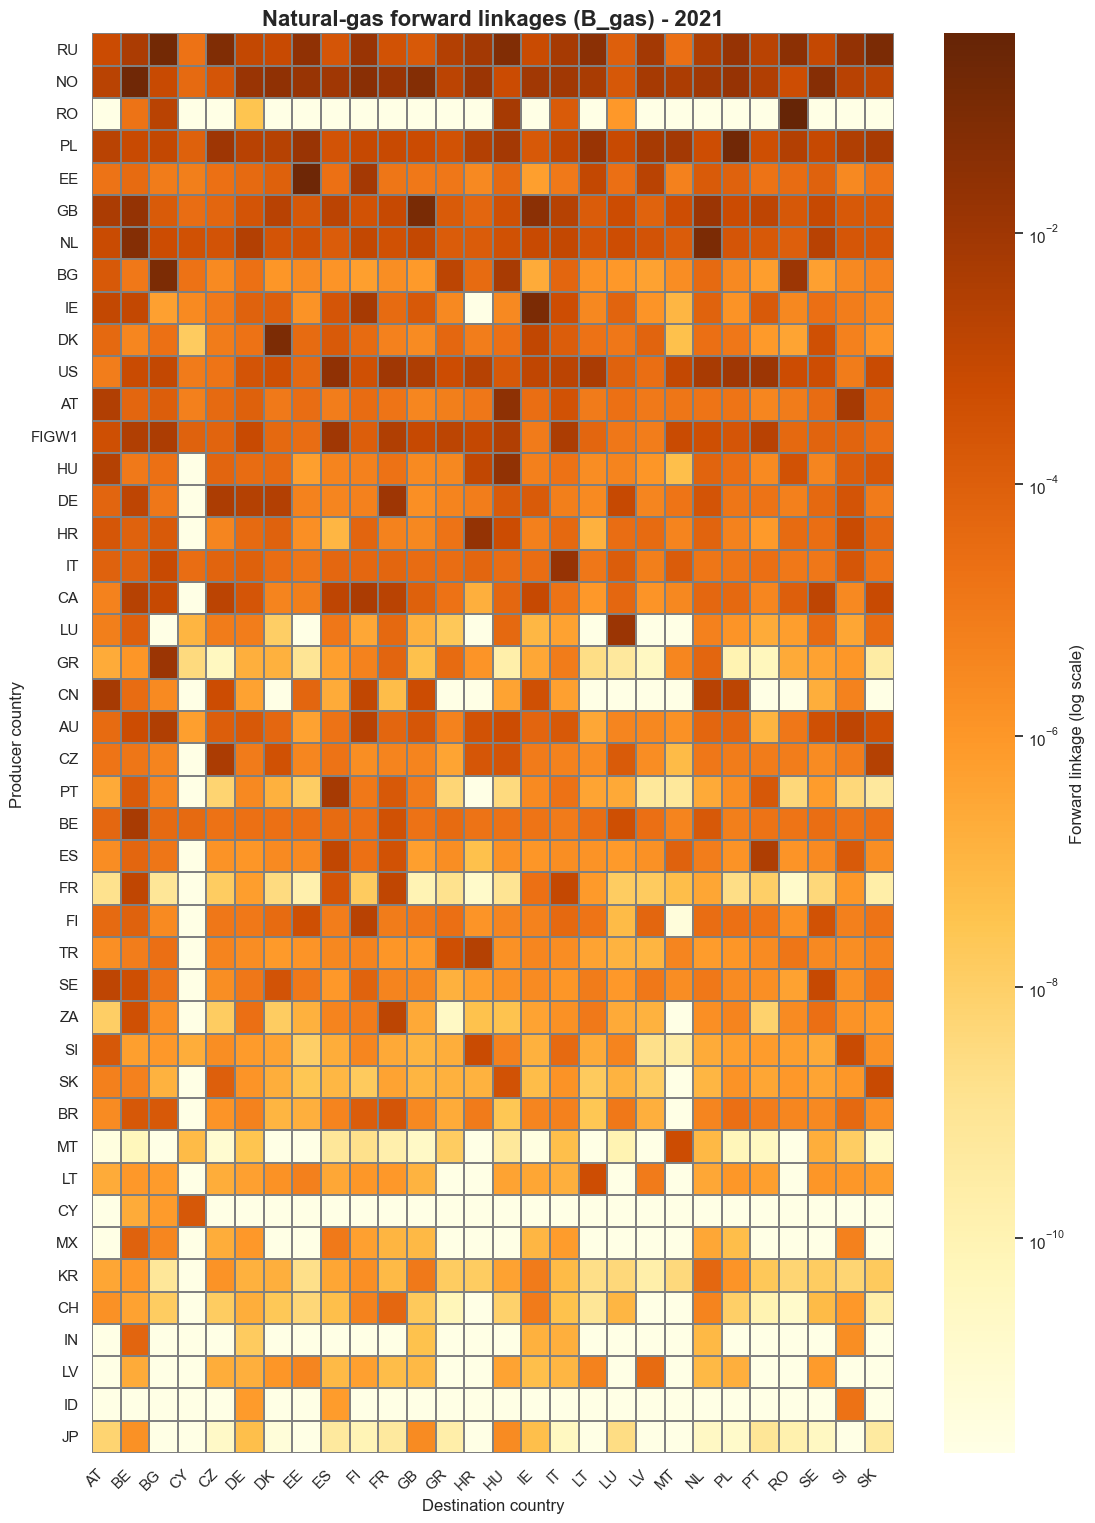

In [40]:
# Save a log-scale version, columns sorted by impact, rows by alphabet
plot_gas_flow_heatmap_multiindex(
    year=2021,
    log_scale=True,
    sort_cols="alphabet",
    sort_rows="impact",
    save=True
)

# Save a linear-scale version, columns sorted alphabetically
plot_gas_flow_heatmap_multiindex(
    year=2021,
    log_scale=True,
    sort_cols="alphabet",
    sort_rows="impact",
    save=False
)


In [41]:
# Use this to get shock results including domestic B_gas production

UNweighted_impacts_EXTRA      = pd.read_csv(GAS_PRICE_SHOCK_OUTPUTS / "results_extra_2021.csv",
                                    index_col=["Country", "Sector"])

UNweighted_impacts_INTRA_EXTRA = pd.read_csv(GAS_PRICE_SHOCK_OUTPUTS / "results_intra_extra_2021.csv",
                                     index_col=["Country", "Sector"])

CPI_CTRY_EXTRA        = pd.read_csv(GAS_PRICE_SHOCK_OUTPUTS / "weighted_impacts" / "cpi_country_impacts_extra_2021.csv",
                                    index_col=["Country", "Sector"])

CPI_CTRY_INTRA_EXTRA  = pd.read_csv(GAS_PRICE_SHOCK_OUTPUTS / "weighted_impacts" / "cpi_country_impacts_intra_extra_2021.csv",
                                    index_col=["Country", "Sector"])

CPI_EU28_EXTRA        = pd.read_csv(GAS_PRICE_SHOCK_OUTPUTS / "weighted_impacts" / "cpi_applied_total_impact_eu28_extra.csv",
                                    index_col=["Country", "Sector"])

CPI_EU28_INTRA_EXTRA  = pd.read_csv(GAS_PRICE_SHOCK_OUTPUTS / "weighted_impacts" / "cpi_applied_total_impact_eu28_intra_extra.csv",
                                    index_col=["Country", "Sector"])

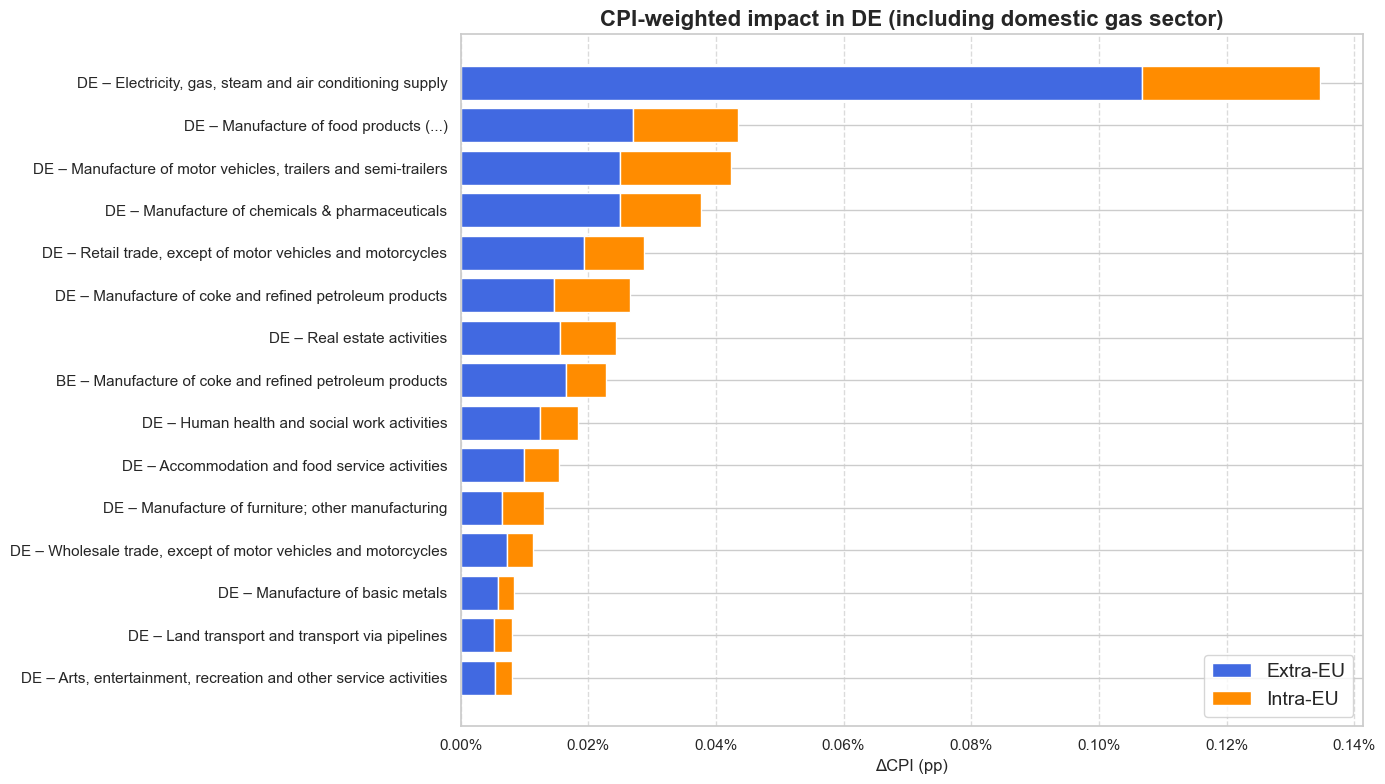

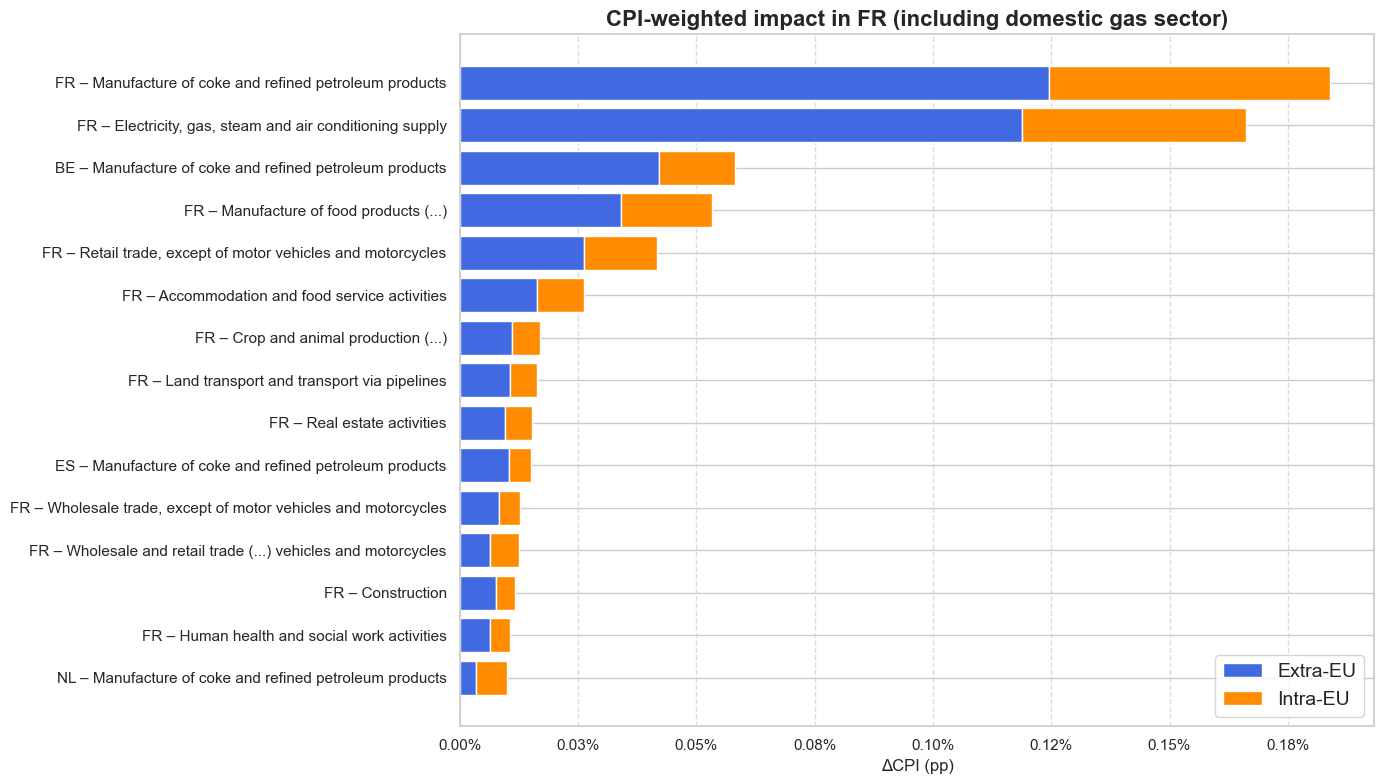

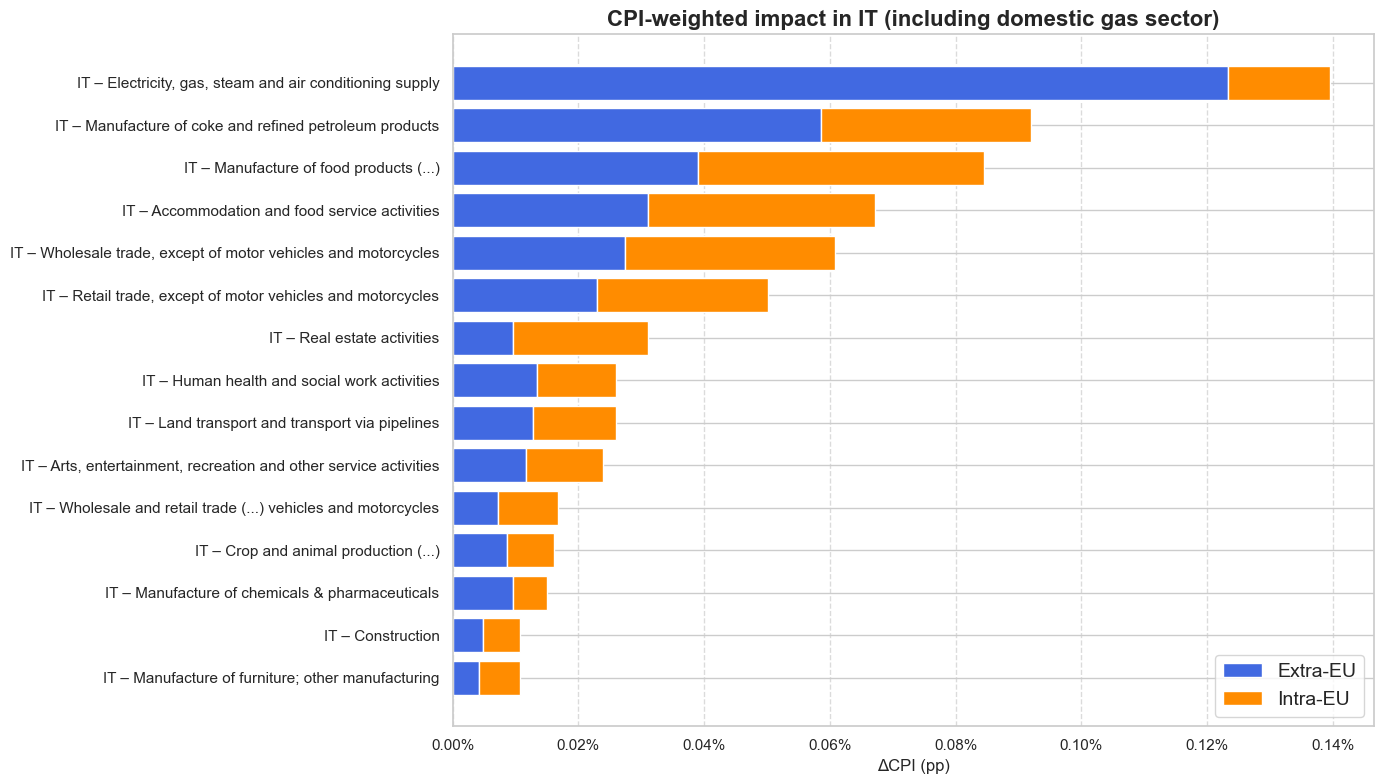

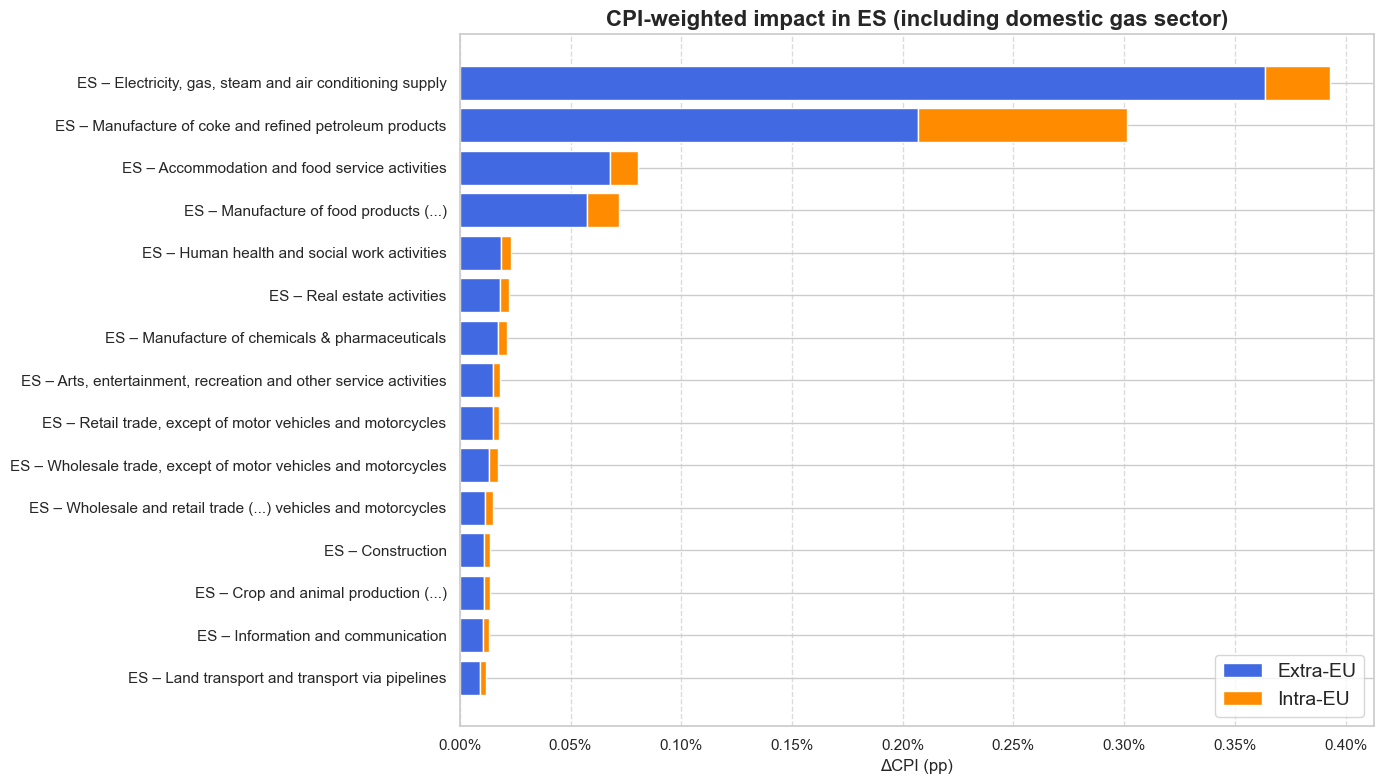

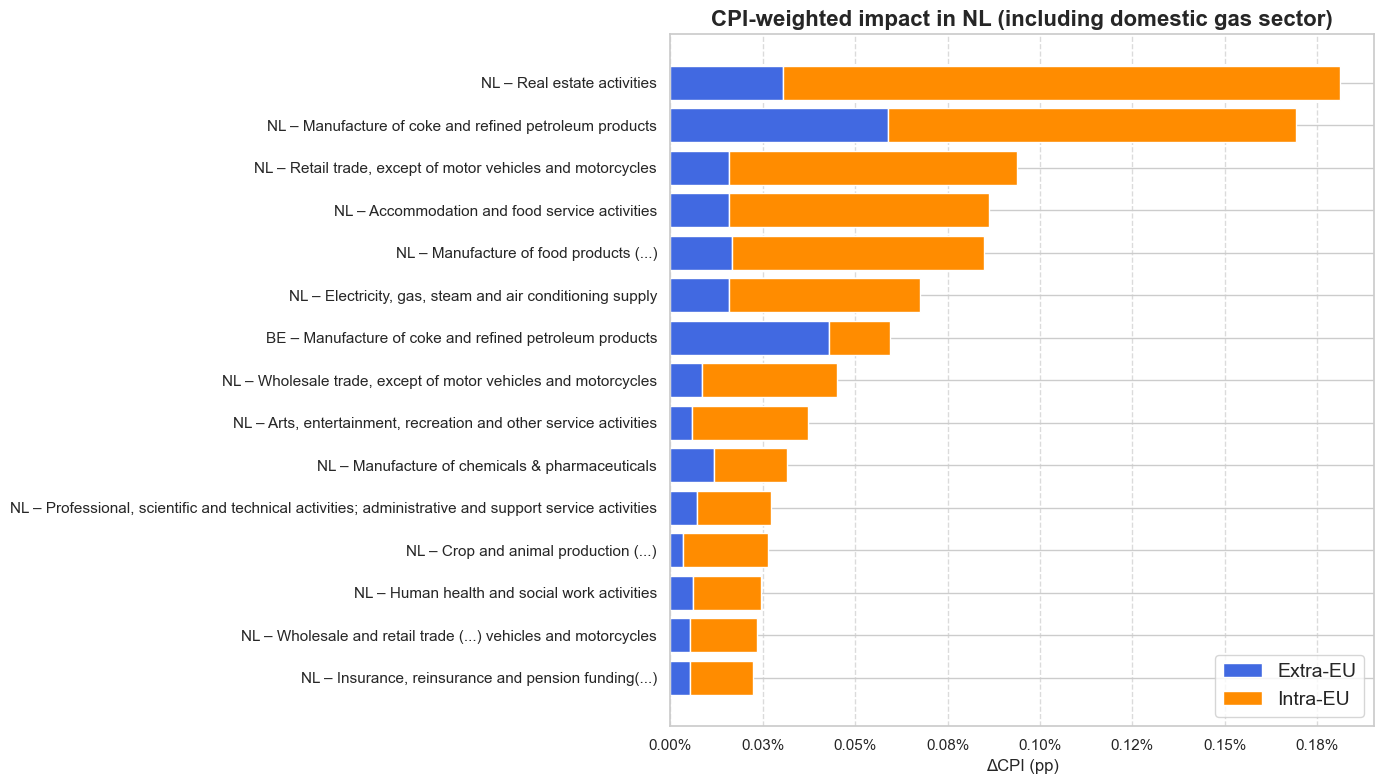

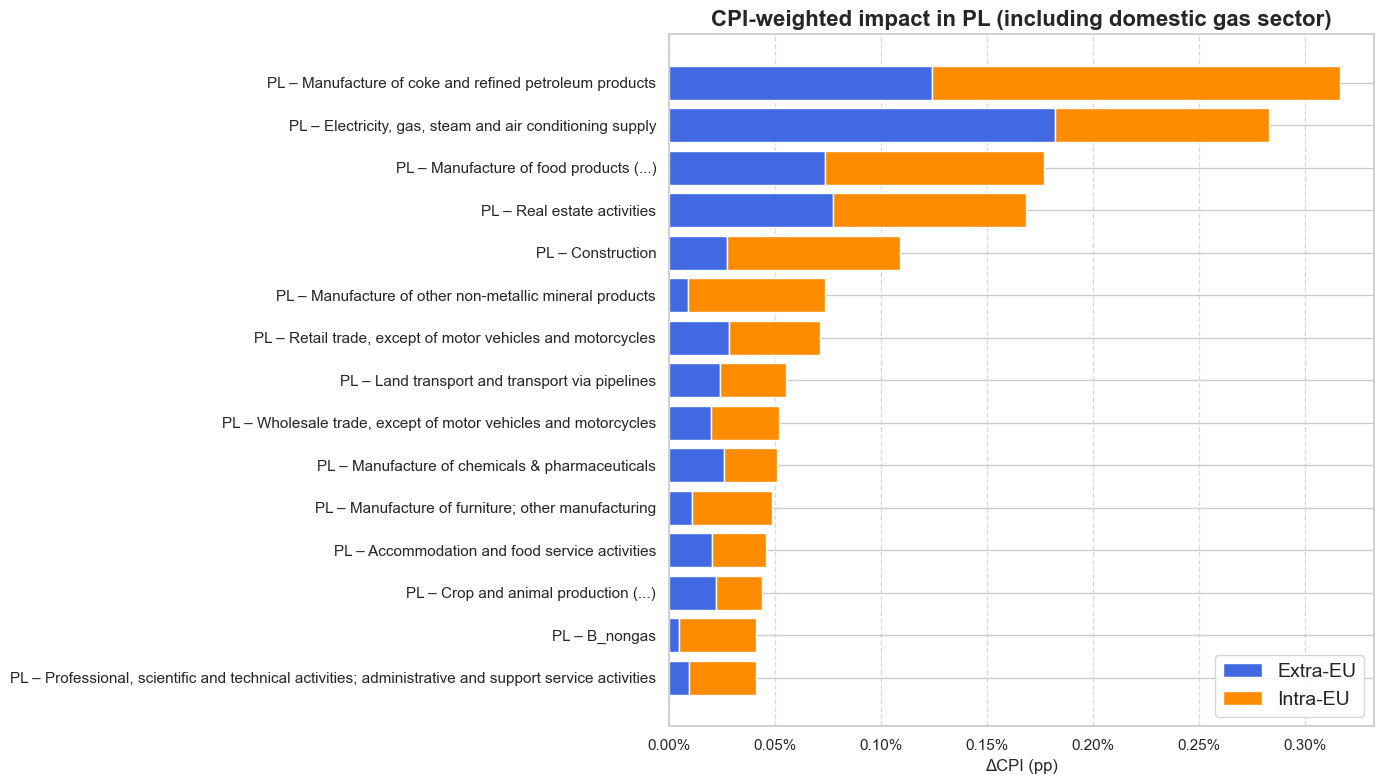

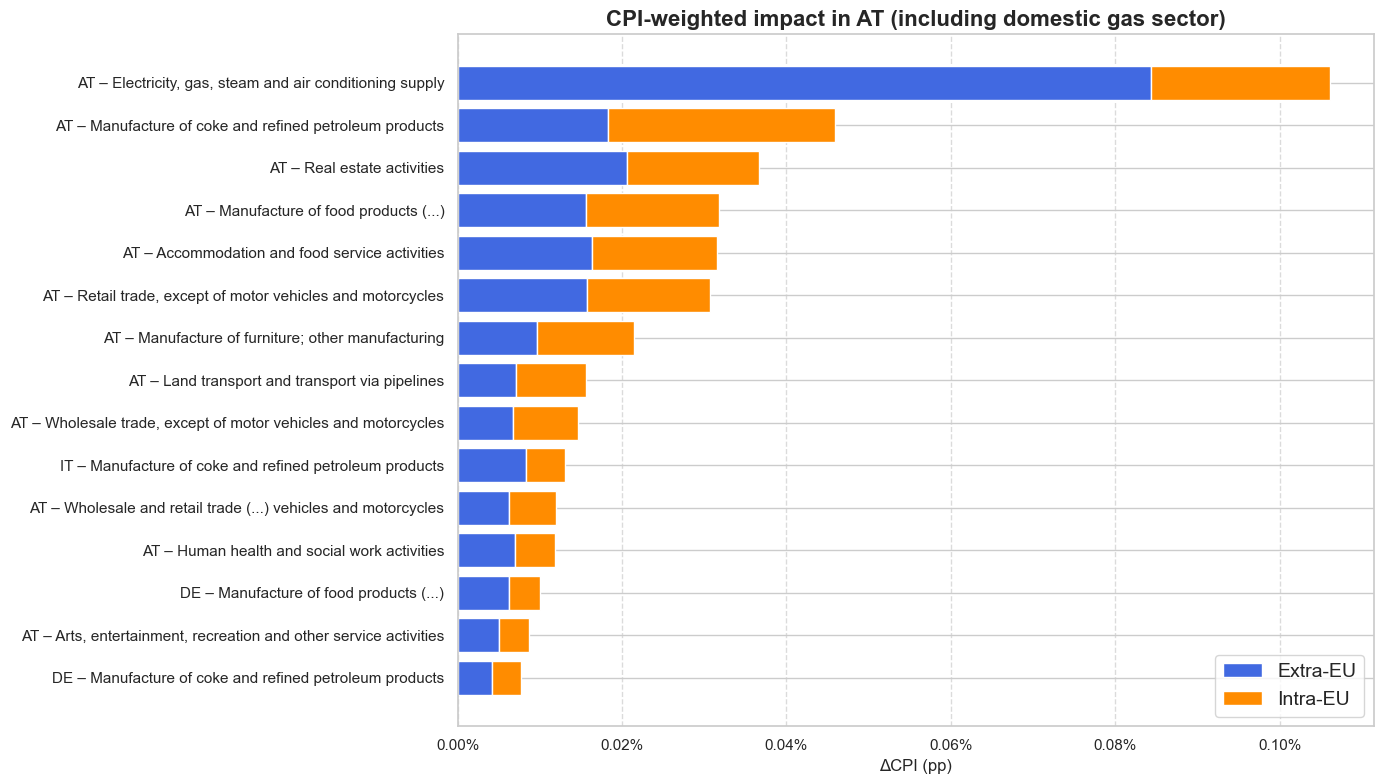

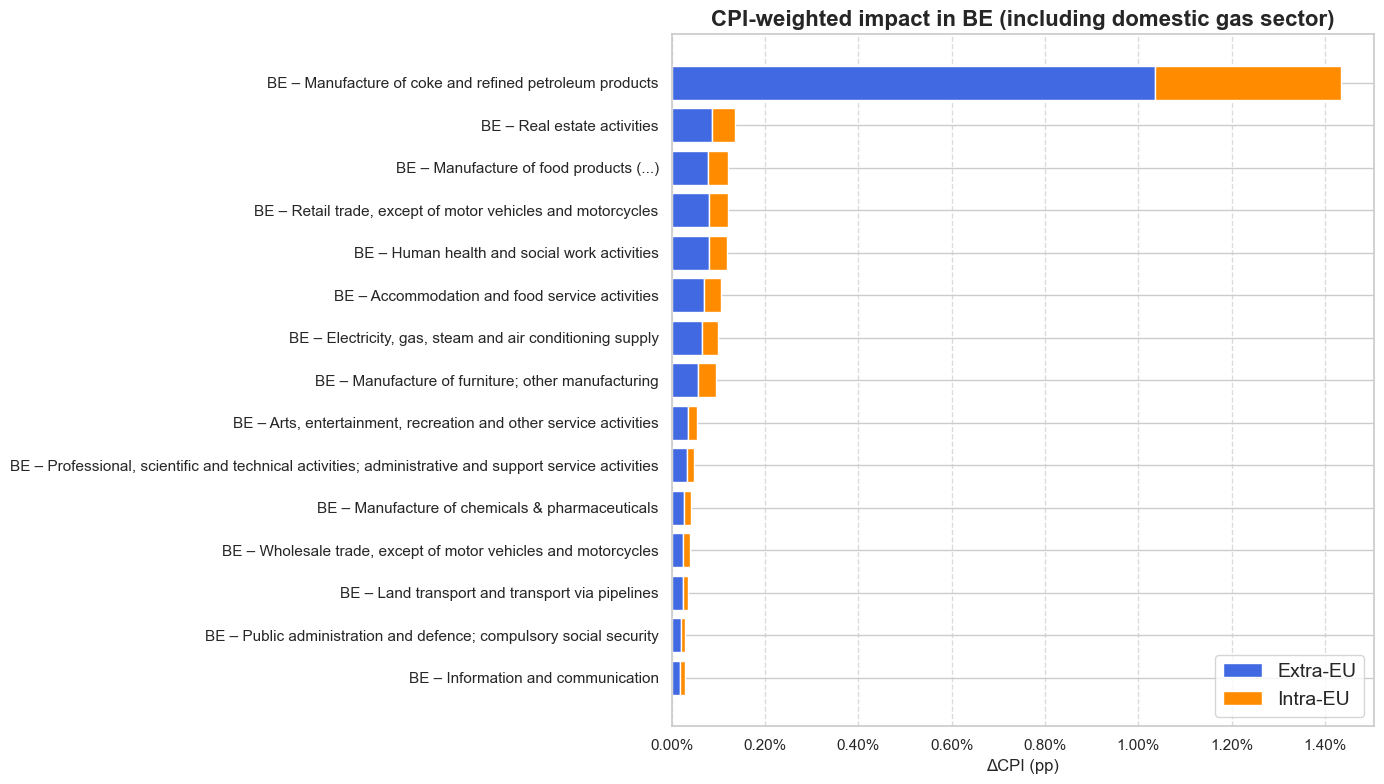

Saved: C:\Users\danie\Nextcloud\Coding\Masterthesis\part_gas_price_shock\visualizations\Origin_Country_Stack_EU28.png
Done C:\Users\danie\Nextcloud\Coding\Masterthesis\part_gas_price_shock\visualizations\Incl_Dom_Destination_Cumulative_Stack_EU28.png
Done C:\Users\danie\Nextcloud\Coding\Masterthesis\part_gas_price_shock\visualizations\Incl_Dom_Sector_Cumulative_Stack_EU28_top15.png


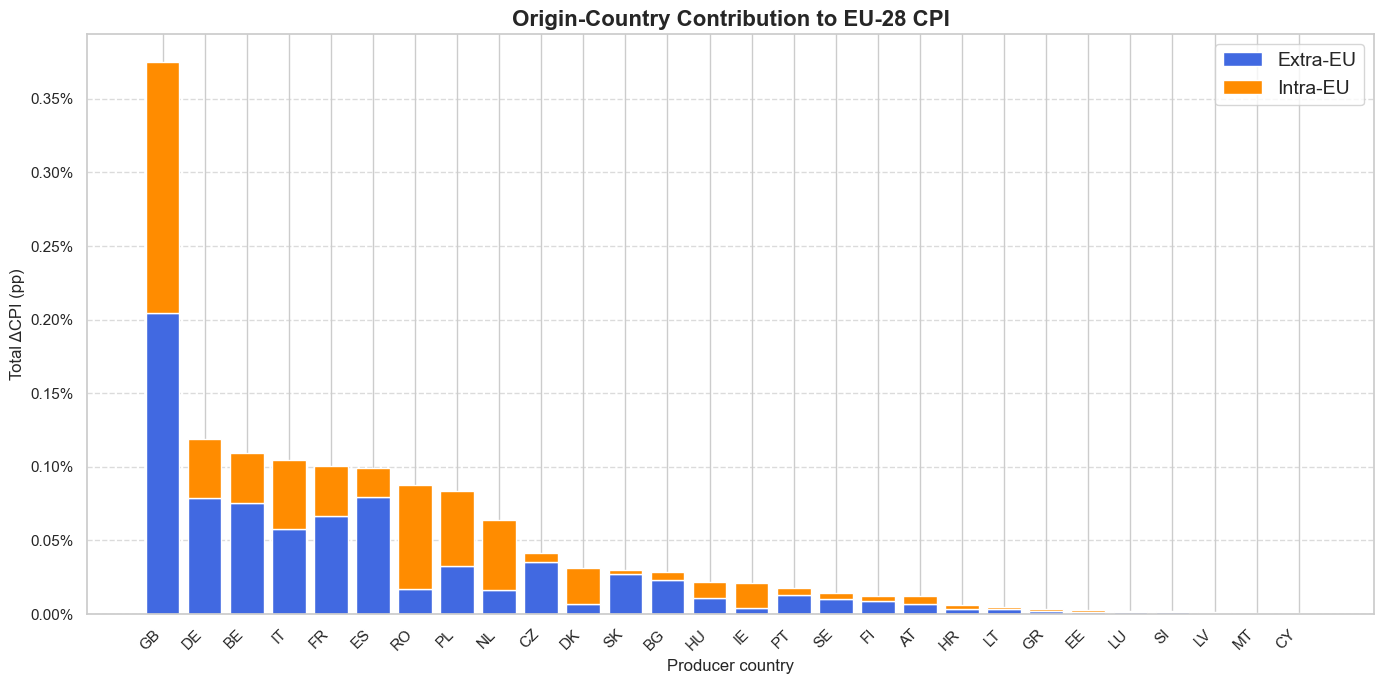

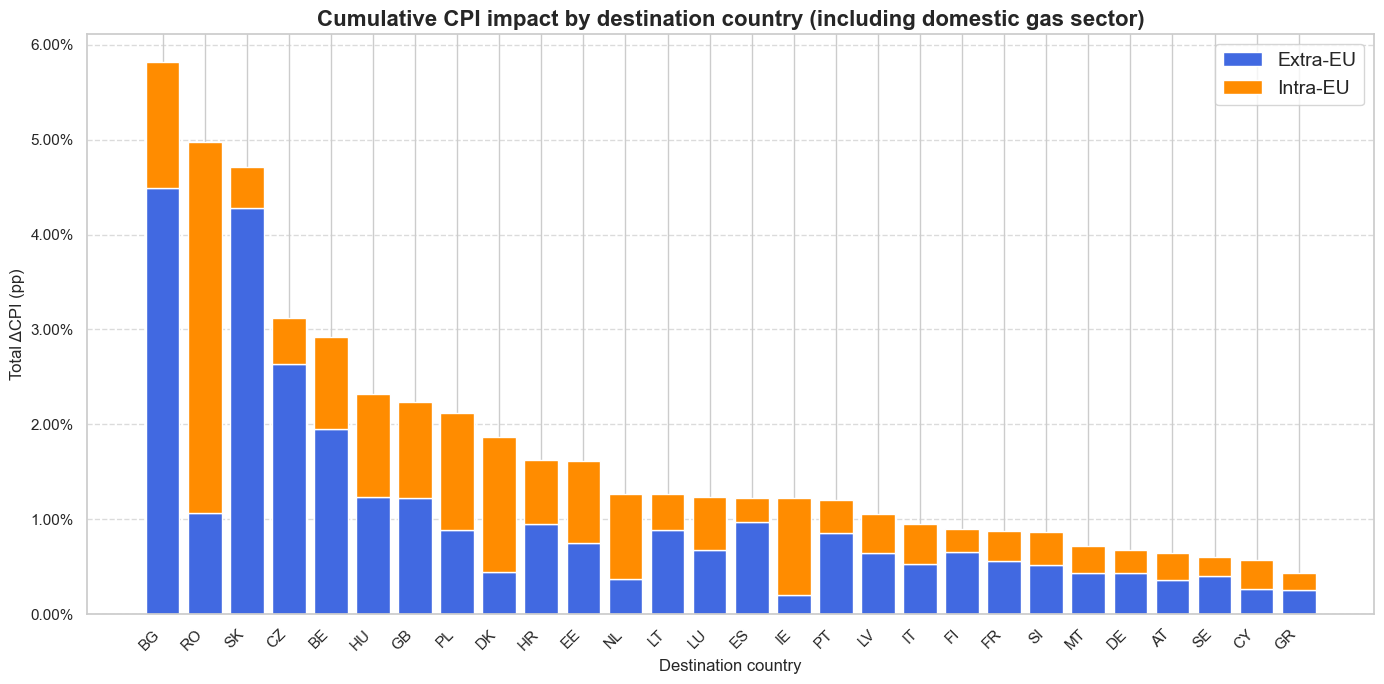

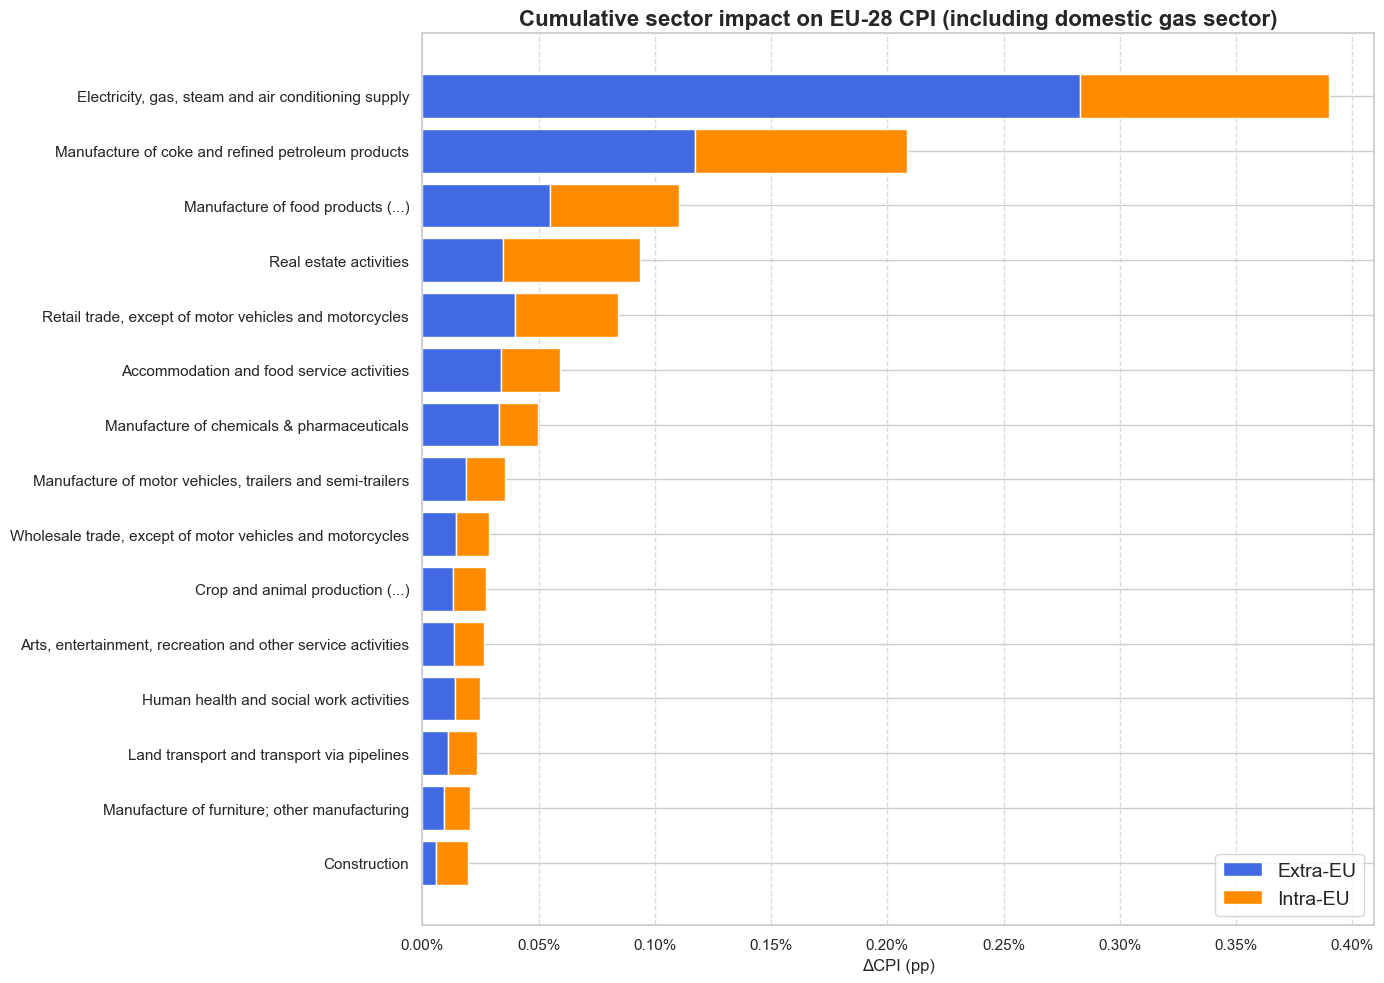

In [42]:
def incl_dom_plot_country_stack_h_sorted(country, *, multiply_100=False):
    code = country.strip().upper()
    # column name: ISO or ISO_impact
    if code in CPI_CTRY_EXTRA.columns:
        col = code
    elif f"{code}_impact" in CPI_CTRY_EXTRA.columns:
        col = f"{code}_impact"
    else:
        raise KeyError(f"No column for '{code}'")
    
    extra = CPI_CTRY_EXTRA[col].copy()
    intra_extra = CPI_CTRY_INTRA_EXTRA[col].copy()
    if multiply_100:
        extra *= 100
        intra_extra *= 100
    
    # largest first (no reverse)
    top20 = intra_extra.nlargest(15)
    
    labels = [
        f"{idx[0]} – {NACE_SHORT_DESCRIPTION_MAP.get(idx[1], idx[1])}"
        for idx in top20.index
    ]
    
    diff = intra_extra.loc[top20.index] - extra.loc[top20.index]
    
    fig, ax = plt.subplots(figsize=(14, 8))
    y = range(len(top20))
    ax.barh(y, extra.loc[top20.index], color="royalblue", label="Extra-EU")
    ax.barh(y, diff, left=extra.loc[top20.index],
            color="darkorange", label="Intra-EU")
    
    unit = "pp" if multiply_100 else "points"
    ax.set(
        title=f"CPI-weighted impact in {code} (including domestic gas sector)",
        xlabel=f"ΔCPI ({unit})",
        yticks=y,
        yticklabels=labels
    )
    
    ax.set_title(ax.get_title(), fontsize=16, fontweight="bold")
    ax.invert_yaxis()   # keeps largest (y=0) at top
    ax.grid(axis="x", linestyle="--", alpha=0.7)
    if multiply_100:
        bar_perc(ax, axis="x")
    ax.legend(loc="lower right")
    fig.tight_layout()
    plt.show()

incl_dom_plot_country_stack_h_sorted("DE", multiply_100=True)
incl_dom_plot_country_stack_h_sorted("FR", multiply_100=True)
incl_dom_plot_country_stack_h_sorted("IT", multiply_100=True)
incl_dom_plot_country_stack_h_sorted("ES", multiply_100=True)
incl_dom_plot_country_stack_h_sorted("NL", multiply_100=True)
incl_dom_plot_country_stack_h_sorted("PL", multiply_100=True)
incl_dom_plot_country_stack_h_sorted("AT", multiply_100=True)
incl_dom_plot_country_stack_h_sorted("BE", multiply_100=True)

def incl_dom_plot_origin_country_stack(*, save=True, multiply_100=False):
    """
    Stacked bar: total CPI impact on the EU-28, summed by *producer* country.

    Parameters
    ----------
    save          : bool   — if True, PNG is written to GAS_PRICE_SHOCK_VIS
    multiply_100  : bool   — if True, convert CPI points → percentage-points
    """
    # ---------------------------------------------------------------
    # Determine which column contains the EU-wide CPI impact
    # ---------------------------------------------------------------
    if "EU28_impact" in CPI_EU28_EXTRA.columns:
        col = "EU28_impact"
    elif "EU28" in CPI_EU28_EXTRA.columns:
        col = "EU28"
    else:
        raise KeyError("Neither 'EU28_impact' nor 'EU28' column found "
                       "in CPI_EU28_EXTRA.")

    # ---------------------------------------------------------------
    # Aggregate by producer country (index level 0)
    # ---------------------------------------------------------------
    extra_by_origin       = CPI_EU28_EXTRA.groupby(level=0)[col].sum()
    intra_extra_by_origin = CPI_EU28_INTRA_EXTRA.groupby(level=0)[col].sum()
    intra_only_by_origin  = intra_extra_by_origin - extra_by_origin

    if multiply_100:
        extra_by_origin      *= 100
        intra_only_by_origin *= 100
        intra_extra_by_origin *= 100

    # Sort countries by total impact (descending)
    order = intra_extra_by_origin.sort_values(ascending=False).index

    # ---------------------------------------------------------------
    # Plot
    # ---------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(14, 7))

    ax.bar(order, extra_by_origin.loc[order],
           label="Extra-EU",  color="royalblue")
    ax.bar(order, intra_only_by_origin.loc[order],
           bottom=extra_by_origin.loc[order],
           label="Intra-EU",  color="darkorange")

    unit = "pp" if multiply_100 else "points"
    ax.set(
        title="Producer-country contribution to EU-28 CPI (including domestic gas sector)",
        ylabel=f"Total ΔCPI ({unit})",
        xlabel="Producer country"
    )
    ax.set_title(ax.get_title(), fontsize=16, fontweight="bold")
    ax.tick_params(axis="x", labelrotation=45)     # rotate
    plt.setp(ax.get_xticklabels(), ha="right")     # align right

    ax.grid(axis="y", linestyle="--", alpha=0.7)

    # format y-axis as percentages if we scaled ×100
    if multiply_100:
        ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:.2f}%"))

    ax.legend(loc="upper right")
    fig.tight_layout()

    if save:
        fname = GAS_PRICE_SHOCK_VIS / "ncl_dom_origin_country_stack_eu28.png"
        fig.savefig(fname, dpi=300)
        print("Done", fname)
    else:
        plt.show()

plot_origin_country_stack(multiply_100=True)

# -------------------------------------------------------------------
# Cumulative destination-side impact (EU-28 countries)
# -------------------------------------------------------------------
def incl_dom_plot_destination_cumulative_stack(*, multiply_100=False, save=True):
    """
    Stacked bars: total CPI impact PER DESTINATION country (EU-28).

    Parameters
    ----------
    multiply_100 : bool  – show percentage-points (×100) instead of CPI points
    save         : bool  – if True, PNG is written to GAS_PRICE_SHOCK_VIS
    """

    # --- determine column naming scheme --------------------------------
    sample_col = next(iter(CPI_CTRY_EXTRA.columns))
    use_suffix  = sample_col.endswith("_impact")          # e.g. "DE_impact"

    # list of destination ISO codes (import from config or define here)
    from config import EU28_COUNTRIES
    dest_cols = [f"{c}_impact" if use_suffix else c for c in EU28_COUNTRIES]

    # --- aggregate over all producer/sector rows -----------------------
    extra_total       = CPI_CTRY_EXTRA[dest_cols].sum(axis=0)
    intra_extra_total = CPI_CTRY_INTRA_EXTRA[dest_cols].sum(axis=0)
    intra_only_total  = intra_extra_total - extra_total

    if multiply_100:
        extra_total       *= 100
        intra_only_total  *= 100
        intra_extra_total *= 100

    # order bars by total impact (descending)
    order = intra_extra_total.sort_values(ascending=False).index

    # strip "_impact" for cleaner x-labels
    labels = [c.replace("_impact", "") for c in order]

    # --- plot ----------------------------------------------------------
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.bar(labels, extra_total[order], label="Extra-EU",  color="royalblue")
    ax.bar(labels, intra_only_total[order],
           bottom=extra_total[order],    label="Intra-EU", color="darkorange")

    unit = "pp" if multiply_100 else "points"
    ax.set(
        title="Cumulative CPI impact by destination country (including domestic gas sector)",
        ylabel=f"Total ΔCPI ({unit})",
        xlabel="Destination country"
    )
    ax.set_title(ax.get_title(), fontsize=16, fontweight="bold")
    ax.tick_params(axis="x", rotation=45, labelrotation=45)
    plt.setp(ax.get_xticklabels(), ha="right")
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    if multiply_100:
        ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:.2f}%"))

    ax.legend(loc="upper right")
    fig.tight_layout()

    if save:
        fname = GAS_PRICE_SHOCK_VIS / "Incl_Dom_Destination_Cumulative_Stack_EU28.png"
        fig.savefig(fname, dpi=300)
        print("Done", fname)
    else:
        plt.show()

incl_dom_plot_destination_cumulative_stack(multiply_100=True)

def plot_eu28_sector_stack(
    *,
    top_n: int = 30,
    multiply_100: bool = True,
    save: bool = True,
):
    """
    Stacked bars: cumulative CPI impact PER SECTOR for the whole EU-28.

    Parameters
    ----------
    top_n        : int
        Number of sectors to display (default = 30, largest impacts).
    multiply_100 : bool
        If True, convert CPI points to percentage-points (×100) for the x-axis.
    save         : bool
        If True, save the figure as PNG in GAS_PRICE_SHOCK_VIS; otherwise only
        display it inline.
    """
    # ---------------------------------------------------------------
    # Detect the EU-wide impact column
    # ---------------------------------------------------------------
    if "EU28_impact" in CPI_EU28_EXTRA.columns:
        eu_col = "EU28_impact"
    elif "EU28" in CPI_EU28_EXTRA.columns:
        eu_col = "EU28"
    else:
        raise KeyError("EU-wide impact column not found in EU-28 tables.")

    # ---------------------------------------------------------------
    # Aggregate CPI impacts by sector
    # ---------------------------------------------------------------
    extra_sec       = CPI_EU28_EXTRA.groupby(level="Sector")[eu_col].sum()
    intra_extra_sec = CPI_EU28_INTRA_EXTRA.groupby(level="Sector")[eu_col].sum()
    intra_only_sec  = intra_extra_sec - extra_sec

    if multiply_100:
        extra_sec       *= 100
        intra_only_sec  *= 100
        intra_extra_sec *= 100

    # Select TOP-N (largest totals) — keep descending order!
    top = intra_extra_sec.nlargest(top_n)      # largest first
    extra_top = extra_sec[top.index]
    intra_top = intra_only_sec[top.index]

    labels = [NACE_SHORT_DESCRIPTION_MAP.get(s, s) for s in top.index]

    # ---------------------------------------------------------------
    # Plot
    # ---------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(14, 10))
    y = range(len(top))
    ax.barh(y, extra_top, color="royalblue", label="Extra-EU")
    ax.barh(y, intra_top, left=extra_top, color="darkorange", label="Intra-EU")

    unit = "pp" if multiply_100 else "points"
    ax.set(
        title="Cumulative sector impact on EU-28 CPI (including domestic gas sector)",
        xlabel=f"ΔCPI ({unit})",
        yticks=y,
        yticklabels=labels,
    )
    ax.set_title(ax.get_title(), fontsize=16, fontweight="bold")
    ax.invert_yaxis()                    # puts y=0 (largest) at the top
    ax.grid(axis="x", linestyle="--", alpha=0.7)
    if multiply_100:
        ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:.2f}%"))
    ax.legend(loc="lower right")
    fig.tight_layout()

    # ---------------------------------------------------------------
    # Save or display
    # ---------------------------------------------------------------
    if save:
        fname = GAS_PRICE_SHOCK_VIS / f"Incl_Dom_Sector_Cumulative_Stack_EU28_top{top_n}.png"
        fig.savefig(fname, dpi=300)
        print("Done", fname)
    else:
        plt.show()

plot_eu28_sector_stack(
    top_n=15,
    multiply_100=True,
    save=True
)